<a href="https://colab.research.google.com/github/Nathalia-Prada/proyecto-integrador-equipo25/blob/main/Avance5Equipo25%20/Avance5Equipo25_forecast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avance 5. Modelo final Series de Tiempo: Forecasting con XGBoost**

3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.


###**Equipo 25**


### Estudiantes


* A01793899 - Andrés Julián López Hurtado
* A01793999 - Nathalia Milena Prada Hernández
* A01794404 - Victor Alejandro Regueira Romero

Fecha: 27 de octubre de 2024

# Instrucciones
En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.



Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.



Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
- Curva ROC
- Matriz de confusión
- Curva de Precisión-Recall
- Análisis de residuos
- Gráfico de importancia de características
- Tendencia y predicción (para series temporales)
- Diagrama de árbol (para árboles de decisión)

# Importar Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerías


Se inicia importando las librerías y leyendo el dataset.

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Rutas de archivos y carga de la base

In [4]:
file_tabla_unida = '/content/drive/MyDrive/TECForza/df_union2.csv'
#file_tabla_unida = '/content/drive/MyDrive/0-Actual/MNA/proyecto_integrador/df_union2.csv'

In [5]:
df_tabla_unida = pd.read_csv(file_tabla_unida)
df_tabla_unida.head()

,name,date,total_distance_used_sum,total_fuel_used_sum,consumption,performance,distance,idlingDuration,idlingPercent,idlingDuration_hours,...,ExcessiveSpeedingCount,ExcessiveSpeedingDistance,HardAccelerationCount,HardAccelerationDistance,HarshBrakingCount,HarshBrakingDistance,HarshCorneringDuration,HarshCorneringCount,HarshCorneringDistance,MaxSpeed
0,986,2024-07-01,115.575006,15.321976,7.543088,0.132572,30.063228,08:12:02,87.0,8.20,...,159.0,50.848373,133.0,0.057267,1.0,0.000096,0.0,43.0,0.006195,83.885109
1,1038,2024-07-01,167.770170,25.096340,6.685045,0.149588,72.647624,06:53:43,62.0,6.90,...,19.0,2.382248,17.0,0.002865,0.0,0.000000,0.0,28.0,0.002594,76.428658
2,502,2024-07-02,1025.262150,68.948892,8.653096,0.067250,912.121800,11:00:31,46.0,11.01,...,105.5,38.452164,48.0,0.020623,0.5,0.000332,0.0,39.5,0.009367,42.874611
3,532,2024-07-02,1103.554896,75.817364,14.555437,0.068703,554.235964,01:34:01,14.0,1.57,...,3.5,0.055369,77.5,0.065764,0.0,0.000000,0.0,18.5,0.007460,38.835701
4,880,2024-07-02,857.491980,64.193796,13.357864,0.074862,429.840038,20:46:51,73.0,20.78,...,402.0,123.554245,59.0,0.020675,0.0,0.000000,0.0,37.0,0.020335,83.885109


# Variables seleccionadas y datasets

In [6]:
df_tabla_unida.columns

Index(['name', 'date', 'total_distance_used_sum', 'total_fuel_used_sum',
       'consumption', 'performance', 'distance', 'idlingDuration',
       'idlingPercent', 'idlingDuration_hours', 'CurrentFuelPrice',
       'IdlingCost', 'SpeedLimit1Count', 'SpeedLimit2Count',
       'SpeedLimit3Count', 'TotalDrivingDuration', 'AverageSpeed',
       'StopUnder10Count', 'StopOver10Count', 'StopOver20Count',
       'StopOver30Count', 'StopOver40Count', 'StopOver50Count',
       'IdlingOver5Count', 'IdlingDuration', 'AfterHoursTripCount',
       'TotalDistance', 'TotalStopsCount', 'SpeedingDuration', 'SpeedingCount',
       'SpeedingDistance', 'ExcessiveSpeedingDuration',
       'ExcessiveSpeedingCount', 'ExcessiveSpeedingDistance',
       'HardAccelerationCount', 'HardAccelerationDistance',
       'HarshBrakingCount', 'HarshBrakingDistance', 'HarshCorneringDuration',
       'HarshCorneringCount', 'HarshCorneringDistance', 'MaxSpeed'],
      dtype='object')

In [7]:
selected_columns = ['date', 'consumption']
df = df_tabla_unida[selected_columns]

Para el análisis de series de tiempo, se necesitan únicamente el consumo y la fecha del viaje, en este caso, las columnas `consumption` y `date`, respectivamente. Se asignará la columna `date` al índice del dataframe; sin embargo, antes debe convertirse de tipo *object* a *datetime* utilizando el método `to_datetime` de la librería Pandas. Finalmente, se muestra el consumo en una frecuencia de acumulado diario.

In [8]:
#convertir a datetime
df['date'] = pd.to_datetime(df['date'])
df_fc = df.set_index('date')

<ipython-input-8-6668be612607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [9]:
#crear acumulado diario
count_date = df_fc.groupby(df_fc.index.date)['consumption'].sum()
fc_clean = pd.DataFrame(count_date)
fc_clean['date'] = pd.to_datetime(fc_clean.index)
fc_clean = fc_clean.set_index('date')

In [10]:
fc_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-07-01 to 2024-08-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


El primer paso en cualquier análisis de series de tiempo es graficar los datos. La visualización permite detectar patrones, lecturas atípicas, variaciones en el tiempo y la relación entre variables.

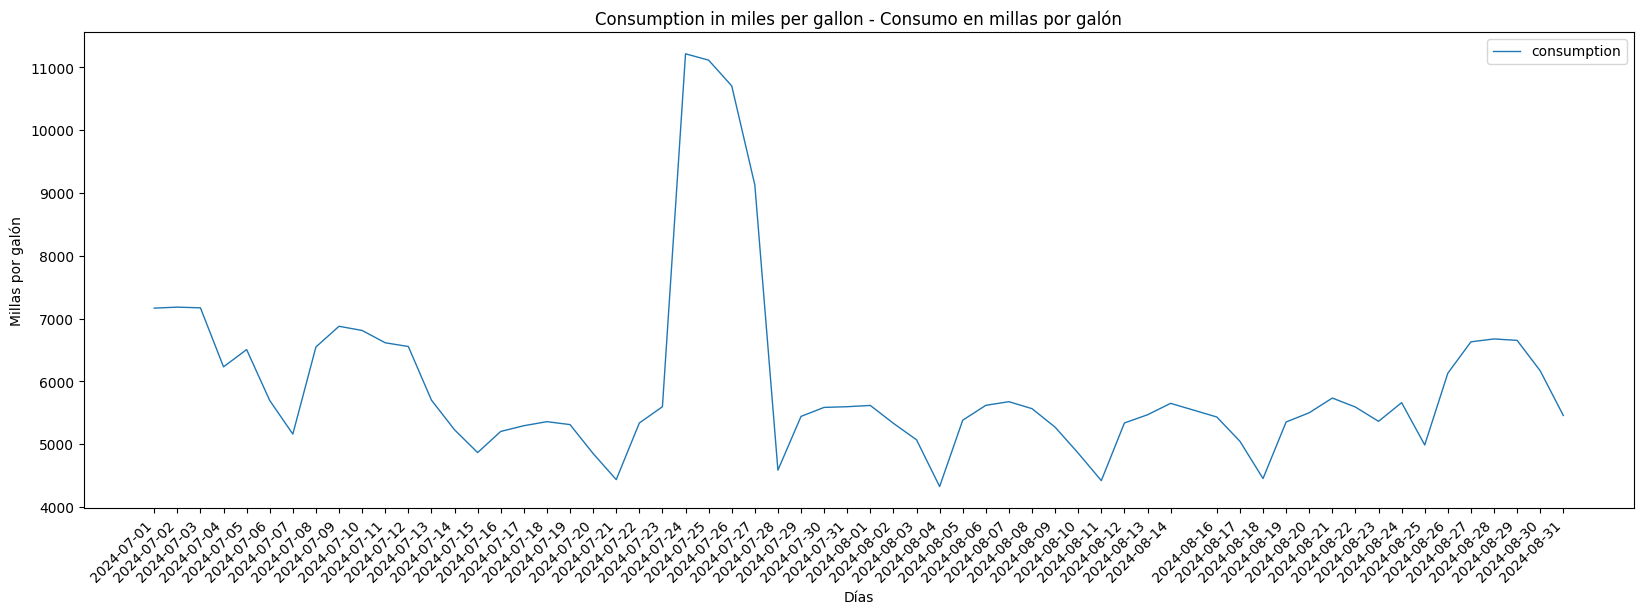

In [11]:
fc_clean.plot(style='-', figsize=(20, 7), lw=1, title='Consumption in miles per gallon - Consumo en millas por galón')

# Establecer la frecuencia de etiquetas del eje x para mostrar todos los días
plt.xticks(fc_clean.index, rotation=45)  # Rotación opcional para mejorar la visibilidad
plt.xlabel('Días')
plt.ylabel('Millas por galón')

plt.show()

# 1. Tendencias Generales
- **Disminución Inicial**: Desde el 1 de julio hasta el 8 de julio, se observa una ligera tendencia a la baja en el consumo, cayendo de aproximadamente 7166 a 5161.
- **Aumento Moderado**: Entre el 8 y el 15 de julio, el consumo muestra un aumento gradual, alcanzando un máximo de 6615 el 11 de julio.
- **Fluctuaciones a partir de la Segunda Quincena de Julio**: Desde el 15 de julio, el consumo comienza a fluctuar significativamente, con un notable aumento hacia el final del mes.

# 2. Picos de Consumo
- **Picos Notables**: Se identifican picos significativos en:
  - 24 de julio: 11,215.996 (consumo excepcionalmente alto).
  - 25 de julio: 11,114.945 (otro día de consumo muy alto).
  
  Estos dos días se destacan como anomalías en comparación con el resto del mes.

# 3. Tendencias en Agosto
- **Recuperación de Consumo**: Tras los picos de julio, el consumo desciende a valores más bajos en los primeros días de agosto, pero mantiene una tendencia moderadamente estable con ligeros picos y caídas.
- **Consumo en la Mitad de Agosto**: Hacia mediados de agosto, se observan incrementos progresivos, especialmente alrededor del 19 y 20 de agosto.
- **Fluctuaciones a Finales de Agosto**: Al final de agosto, el consumo muestra una variabilidad, pero en general se mantiene dentro de un rango similar al de principios de mes.

# Conclusiones
- **Picos en Consumo**: Los días 24 y 25 de julio muestran consumos extraordinarios, lo que podría indicar algún evento o actividad especial.
- **Tendencia a la Baja Inicial**: Después de los picos, el consumo disminuye, pero se observa cierta recuperación y variabilidad en agosto.
- **Consumo Generalmente Estable**: A pesar de las fluctuaciones, el consumo se mantiene en un rango relativamente constante a lo largo de agosto, con algunos picos y valles menores.

# Modelo XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo Gradient Boosting (GBM) para tareas de aprendizaje supervisado, como regresión y clasificación. Este algoritmo utiliza ensambles de árboles de decisión (Tree Ensembles) para combinar múltiples modelos "débiles" y producir un modelo predictivo de mayor precisión. XGBoost aplica la técnica de boosting como método de ensamble y utiliza descenso de gradiente para optimizar el proceso, brindando gran flexibilidad en el ajuste de hiperparámetros para controlar la complejidad y mitigar el sobreentrenamiento (overfitting). También soporta el tratamiento de valores faltantes y variables categóricas.

Para este análisis, solo se ajustarán los siguientes hiperparámetros:

- **booster**: Tipo de modelo utilizado; por defecto, `gbtree`, que emplea árboles de decisión.
- **n_estimators**: Número de modelos en el ensamble. Un valor bajo puede causar underfitting, mientras que uno muy alto puede llevar al sobreentrenamiento.
- **early_stopping_rounds**: Número de iteraciones tras el cual se detiene automáticamente el entrenamiento si no mejora el score de validación. Este parámetro suele utilizarse con un valor alto de `n_estimators`, permitiendo que `early_stopping_rounds` determine el número óptimo de iteraciones.
- **objective**: Define la tarea de aprendizaje y el objetivo de optimización. En este caso, se especifica `'reg:squarederror'` para regresión con error cuadrático.
- **reg_lambda**: Parámetro de regularización, equivalente a Ridge (L2) en regresiones múltiples, que penaliza de forma uniforme todos los pesos del modelo. Un valor más alto hace el modelo más conservador.
- **max_depth**: Profundidad máxima de los árboles de decisión. Una mayor profundidad puede mejorar el ajuste, pero incrementa el riesgo de sobreentrenamiento.
- **eta**: Tasa de aprendizaje en cada iteración. Un valor mayor permite una convergencia más rápida, aunque podría "saltar" el valor óptimo; un valor menor ofrece un ajuste más gradual, aunque puede no alcanzar el mínimo de la función objetivo.

## Creación de Atributos (feature engineering)

De momento, el dataset solo contiene la variable de salida ('Consumption in miles per gallon - Consumo en millas por galón).

El siguiente paso consiste en agregar características que ayuden a explicar el comportamiento de esta variable. Para ello, se aprovechan los métodos de la librería Pandas para manipular datos de tipo `datetime`. Se define una función para crear variables adicionales basadas en el índice de la serie de tiempo:

In [12]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

fc_clean = create_attributes(fc_clean)
fc_clean

,consumption,day,dayofweek,month,quarter,year,dayofyear
date,,,,,,,
2024-07-01,7166.415676,1,0,7,3,2024,183
2024-07-02,7182.232302,2,1,7,3,2024,184
2024-07-03,7171.074568,3,2,7,3,2024,185
2024-07-04,6231.688432,4,3,7,3,2024,186
2024-07-05,6506.612911,5,4,7,3,2024,187
...,...,...,...,...,...,...,...
2024-08-27,6630.083851,27,1,8,3,2024,240
2024-08-28,6675.791509,28,2,8,3,2024,241
2024-08-29,6653.025786,29,3,8,3,2024,242


### Entrenando el Modelo

Antes del entrenamiento, se divide el conjunto de datos en un set de prueba y otro de validación. Es importante recordar que, en el caso de series de tiempo, no es adecuado realizar una división aleatoria para la validación cruzada (cross-validation), debido a la correlación entre observaciones cercanas en el tiempo.

Para abordar esto, se utiliza la clase `TimeSeriesSplit` de la librería Scikit-learn. En este caso, se configuran cinco particiones para la validación cruzada, permitiendo que el modelo se entrene y valide de manera secuencial. La métrica de evaluación seleccionada es el error absoluto medio (MAE), que proporciona una medida directa del error promedio en la predicción. Optuna se encarga de optimizar los hiperparámetros del modelo mediante esta métrica. Una vez obtenidos los mejores parámetros, el modelo final se entrena y evalúa en el conjunto de prueba, proporcionando así una evaluación robusta de su rendimiento en datos no vistos.

In [13]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Definir características y objetivo
features = ['day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
X = fc_clean[features]  # Matriz de características
y = fc_clean['consumption']  # Variable objetivo

# Dividir datos en entrenamiento y prueba (último 20% para prueba)
split_index = int(0.8 * len(fc_clean))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Configurar la división temporal y modelo
tscv = TimeSeriesSplit(n_splits=5)
pipeline = XGBRegressor()

# Función objetivo para optimización de hiperparámetros
def objective(trial):
    # Definir el espacio de hiperparámetros
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 0.5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.0, 3.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    # Actualizar el modelo con los parámetros sugeridos
    pipeline.set_params(**params)

    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Calcular el promedio de los puntajes
    mean_score = np.mean(scores)

    print('Puntajes por partición:', scores)
    print('Puntaje promedio:', mean_score)

    return mean_score

# Configurar y ejecutar Optuna para la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)  # Ajustar n_trials y timeout según necesidad

# Imprimir los mejores parámetros encontrados
optuna_best_params = study.best_params
print("Mejores parámetros encontrados por Optuna:")
print(optuna_best_params)

# Entrenar el modelo con los mejores parámetros
pipeline.set_params(**optuna_best_params)
pipeline.fit(X_train, y_train)

# Calcular puntajes de validación cruzada con mejores parámetros
scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('Puntajes finales por partición con los mejores parámetros:', scores)
print('Puntaje promedio final con los mejores parámetros:', np.mean(scores))

# Predicción y evaluación en el conjunto de prueba
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE después de Optuna: {mae:.2f}")

[I 2024-10-27 15:16:03,335] A new study created in memory with name: no-name-30352ca7-2e60-4104-b406-61b4af14eb5f
<ipython-input-13-2f0aa228f881>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-13-2f0aa228f881>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-13-2f0aa228f881>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Puntajes por partición: [ -732.20812829 -1176.1514862  -2247.00914452  -259.31192545
  -457.52077848]
Puntaje promedio: -974.4402925875271


[I 2024-10-27 15:16:10,682] Trial 1 finished with value: -892.2202438948968 and parameters: {'learning_rate': 0.1530346679836873, 'max_depth': 8, 'subsample': 0.7085282123438698, 'colsample_bytree': 0.7289692309156875, 'reg_alpha': 0.0009451804493724592, 'reg_lambda': 2.627772633238022, 'min_child_weight': 4, 'gamma': 0.02990671110424198, 'n_estimators': 423}. Best is trial 1 with value: -892.2202438948968.


Puntajes por partición: [ -732.20812829 -1083.66006534 -2236.58000633  -219.86174275
  -188.79127676]
Puntaje promedio: -892.2202438948968


[I 2024-10-27 15:16:11,664] Trial 2 finished with value: -1131.8091358706768 and parameters: {'learning_rate': 0.16423486134156834, 'max_depth': 7, 'subsample': 0.9685444542022393, 'colsample_bytree': 0.6842616512128534, 'reg_alpha': 0.00018718605045912217, 'reg_lambda': 1.7358508533158614, 'min_child_weight': 7, 'gamma': 0.3870932320718071, 'n_estimators': 475}. Best is trial 1 with value: -892.2202438948968.


Puntajes por partición: [ -732.20812829 -1238.20806579 -2644.378041    -748.00910199
  -296.24234228]
Puntaje promedio: -1131.8091358706768


[I 2024-10-27 15:16:12,412] Trial 3 finished with value: -1067.5514489689476 and parameters: {'learning_rate': 0.020703739064710135, 'max_depth': 10, 'subsample': 0.7914660744990576, 'colsample_bytree': 0.7904648763135236, 'reg_alpha': 0.2411054461614728, 'reg_lambda': 1.3886753225587996, 'min_child_weight': 7, 'gamma': 0.15517609015875328, 'n_estimators': 344}. Best is trial 1 with value: -892.2202438948968.


Puntajes por partición: [ -732.20812829 -1340.78704528 -2242.33214256  -568.32782088
  -454.10210783]
Puntaje promedio: -1067.5514489689476


[I 2024-10-27 15:16:13,159] Trial 4 finished with value: -1113.529240324728 and parameters: {'learning_rate': 0.1871481437551325, 'max_depth': 10, 'subsample': 0.8609307325916467, 'colsample_bytree': 0.9021689459003627, 'reg_alpha': 0.11229777566633882, 'reg_lambda': 1.3034052167654622, 'min_child_weight': 1, 'gamma': 0.3051135142229971, 'n_estimators': 419}. Best is trial 1 with value: -892.2202438948968.


Puntajes por partición: [ -619.35015707  -989.3503358  -3448.50761885  -337.77249795
  -172.66559195]
Puntaje promedio: -1113.529240324728


[I 2024-10-27 15:16:13,821] Trial 5 finished with value: -1080.1708501403593 and parameters: {'learning_rate': 0.07772034495690305, 'max_depth': 8, 'subsample': 0.9215820567288434, 'colsample_bytree': 0.7272458679707038, 'reg_alpha': 0.03508823419664439, 'reg_lambda': 2.01365375379089, 'min_child_weight': 10, 'gamma': 0.3911733524330836, 'n_estimators': 295}. Best is trial 1 with value: -892.2202438948968.


Puntajes por partición: [ -732.20812829 -1556.80804138 -2289.41894618  -469.52213964
  -352.89699522]
Puntaje promedio: -1080.1708501403593


[I 2024-10-27 15:16:14,749] Trial 6 finished with value: -863.2073582311841 and parameters: {'learning_rate': 0.053749283553529516, 'max_depth': 9, 'subsample': 0.9890141891095425, 'colsample_bytree': 0.6357833463124638, 'reg_alpha': 0.0002144332301867813, 'reg_lambda': 1.2765072884681945, 'min_child_weight': 4, 'gamma': 0.4367015523849602, 'n_estimators': 262}. Best is trial 6 with value: -863.2073582311841.


Puntajes por partición: [ -732.20812829 -1030.94295977 -2208.66637108  -174.16926592
  -170.0500661 ]
Puntaje promedio: -863.2073582311841


[I 2024-10-27 15:16:15,314] Trial 7 finished with value: -1280.9832318666809 and parameters: {'learning_rate': 0.021041258417185873, 'max_depth': 10, 'subsample': 0.6653113196820863, 'colsample_bytree': 0.8299726034773702, 'reg_alpha': 0.009608281631091798, 'reg_lambda': 1.3031048755567605, 'min_child_weight': 10, 'gamma': 0.07848321081271475, 'n_estimators': 193}. Best is trial 6 with value: -863.2073582311841.


Puntajes por partición: [ -732.20812829 -1581.52471618 -2067.45793602 -1292.67618448
  -731.04919437]
Puntaje promedio: -1280.9832318666809


[I 2024-10-27 15:16:15,791] Trial 8 finished with value: -1221.5472951596553 and parameters: {'learning_rate': 0.01457419806523205, 'max_depth': 10, 'subsample': 0.7526094988700469, 'colsample_bytree': 0.826740715445019, 'reg_alpha': 0.06700013913157153, 'reg_lambda': 1.9354731266745973, 'min_child_weight': 8, 'gamma': 0.267953254540886, 'n_estimators': 136}. Best is trial 6 with value: -863.2073582311841.


Puntajes por partición: [ -732.20812829 -1566.58746032 -2173.34581444 -1296.53171426
  -339.06335849]
Puntaje promedio: -1221.5472951596553


[I 2024-10-27 15:16:16,276] Trial 9 finished with value: -1119.643293435503 and parameters: {'learning_rate': 0.11453528745232278, 'max_depth': 7, 'subsample': 0.8875451236217249, 'colsample_bytree': 0.6399653007596505, 'reg_alpha': 0.0003776789797439233, 'reg_lambda': 2.068702982446139, 'min_child_weight': 8, 'gamma': 0.27253402899966184, 'n_estimators': 210}. Best is trial 6 with value: -863.2073582311841.


Puntajes por partición: [ -732.20812829 -1351.78631286 -2290.1469619   -546.07222602
  -678.0028381 ]
Puntaje promedio: -1119.643293435503


[I 2024-10-27 15:16:17,393] Trial 10 finished with value: -803.756792885546 and parameters: {'learning_rate': 0.055358606605671684, 'max_depth': 3, 'subsample': 0.9987888042645439, 'colsample_bytree': 0.9680160793370296, 'reg_alpha': 0.0014077570111137418, 'reg_lambda': 1.0204925517852028, 'min_child_weight': 3, 'gamma': 0.4985544348585318, 'n_estimators': 268}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -779.54351644 -1067.92748424 -1828.62224266  -239.01993448
  -103.67078661]
Puntaje promedio: -803.756792885546


[I 2024-10-27 15:16:18,211] Trial 11 finished with value: -804.3034522884293 and parameters: {'learning_rate': 0.059884616026124014, 'max_depth': 3, 'subsample': 0.9979718207575352, 'colsample_bytree': 0.9929061021725779, 'reg_alpha': 0.0014617033269277181, 'reg_lambda': 1.0029383560013505, 'min_child_weight': 3, 'gamma': 0.48314849580066827, 'n_estimators': 259}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -779.26122884 -1064.45781871 -1818.07896874  -241.37601358
  -118.34323157]
Puntaje promedio: -804.3034522884293


[I 2024-10-27 15:16:18,893] Trial 12 finished with value: -1098.5074887290152 and parameters: {'learning_rate': 0.05331733114695283, 'max_depth': 3, 'subsample': 0.9981889487584317, 'colsample_bytree': 0.9946039334561723, 'reg_alpha': 0.0017624234812545982, 'reg_lambda': 1.0010713367271873, 'min_child_weight': 1, 'gamma': 0.47651244154525696, 'n_estimators': 234}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -548.7498763  -1028.25237438 -3474.07109542  -275.28409463
  -166.18000291]
Puntaje promedio: -1098.5074887290152


[I 2024-10-27 15:16:19,367] Trial 13 finished with value: -819.3356080761674 and parameters: {'learning_rate': 0.08280470122508098, 'max_depth': 3, 'subsample': 0.9374004750636158, 'colsample_bytree': 0.9907779008242, 'reg_alpha': 0.002498253555368557, 'reg_lambda': 1.0137481039449636, 'min_child_weight': 3, 'gamma': 0.4937286737664148, 'n_estimators': 146}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -764.46447591 -1055.08385631 -1917.23039696  -231.44629803
  -128.45301317]
Puntaje promedio: -819.3356080761674


[I 2024-10-27 15:16:20,291] Trial 14 finished with value: -839.4236935960795 and parameters: {'learning_rate': 0.035589175054399735, 'max_depth': 5, 'subsample': 0.8388556514998574, 'colsample_bytree': 0.9253419487600245, 'reg_alpha': 0.0009225554541884556, 'reg_lambda': 1.129723493687338, 'min_child_weight': 3, 'gamma': 0.3551678404401327, 'n_estimators': 324}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -769.63677816  -993.63671782 -2084.47093651  -245.78498857
  -103.58904692]
Puntaje promedio: -839.4236935960795


[I 2024-10-27 15:16:21,045] Trial 15 finished with value: -828.9372154008637 and parameters: {'learning_rate': 0.07351047145517695, 'max_depth': 5, 'subsample': 0.6320041259094609, 'colsample_bytree': 0.9126097965746315, 'reg_alpha': 0.003580302970488905, 'reg_lambda': 1.4704217869152327, 'min_child_weight': 2, 'gamma': 0.2127057313788157, 'n_estimators': 267}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -728.30035238  -976.2465811  -2015.53917381  -256.65408396
  -167.94588575]
Puntaje promedio: -828.9372154008637


[I 2024-10-27 15:16:22,319] Trial 16 finished with value: -927.085336500317 and parameters: {'learning_rate': 0.03773959838538635, 'max_depth': 4, 'subsample': 0.9596131929739562, 'colsample_bytree': 0.9556191715959023, 'reg_alpha': 0.023715878242081212, 'reg_lambda': 1.132574046788268, 'min_child_weight': 5, 'gamma': 0.45097030057996357, 'n_estimators': 379}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -732.20812829 -1130.30282283 -2315.93224022  -211.04090131
  -245.94258985]
Puntaje promedio: -927.085336500317


[I 2024-10-27 15:16:22,997] Trial 17 finished with value: -1088.8093060854308 and parameters: {'learning_rate': 0.010106805999104702, 'max_depth': 5, 'subsample': 0.806825524960343, 'colsample_bytree': 0.849214060458266, 'reg_alpha': 0.0004982415547100036, 'reg_lambda': 2.8728380097579658, 'min_child_weight': 3, 'gamma': 0.3426782539405405, 'n_estimators': 104}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -733.61730798 -1281.31377868 -2119.52922508  -696.03330118
  -613.55291751]
Puntaje promedio: -1088.8093060854308


[I 2024-10-27 15:16:23,771] Trial 18 finished with value: -937.650872344376 and parameters: {'learning_rate': 0.05446288714609881, 'max_depth': 4, 'subsample': 0.9249116981986901, 'colsample_bytree': 0.8725355031494825, 'reg_alpha': 0.004690316041571203, 'reg_lambda': 1.5286704052963702, 'min_child_weight': 5, 'gamma': 0.39487243272137357, 'n_estimators': 177}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -732.20812829 -1092.07775573 -2315.07713768  -291.31521218
  -257.57612784]
Puntaje promedio: -937.650872344376


[I 2024-10-27 15:16:24,815] Trial 19 finished with value: -842.8537585022754 and parameters: {'learning_rate': 0.025614641769589688, 'max_depth': 4, 'subsample': 0.8571464058742639, 'colsample_bytree': 0.9557224464647337, 'reg_alpha': 0.0011857713683063721, 'reg_lambda': 1.1404009976411729, 'min_child_weight': 2, 'gamma': 0.49825292685878225, 'n_estimators': 256}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -671.27514486 -1024.94298717 -2145.33348534  -253.44599931
  -119.27117583]
Puntaje promedio: -842.8537585022754


[I 2024-10-27 15:16:25,684] Trial 20 finished with value: -876.3315405376112 and parameters: {'learning_rate': 0.10740396794760997, 'max_depth': 6, 'subsample': 0.9553345017906023, 'colsample_bytree': 0.7739055124789928, 'reg_alpha': 0.013082893305884994, 'reg_lambda': 2.223848088153195, 'min_child_weight': 4, 'gamma': 0.4291199121940813, 'n_estimators': 314}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -732.20812829 -1105.45025189 -2184.45976708  -213.03929402
  -146.50026142]
Puntaje promedio: -876.3315405376112


[I 2024-10-27 15:16:26,250] Trial 21 finished with value: -812.9029232566397 and parameters: {'learning_rate': 0.07864868719280149, 'max_depth': 3, 'subsample': 0.9991806045430257, 'colsample_bytree': 0.998652794553594, 'reg_alpha': 0.0034624999420158516, 'reg_lambda': 1.0121390629247877, 'min_child_weight': 3, 'gamma': 0.49718901842644003, 'n_estimators': 164}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -779.74194173 -1062.40197155 -1862.71043846  -231.33786661
  -128.32239793]
Puntaje promedio: -812.9029232566397


[I 2024-10-27 15:16:27,163] Trial 22 finished with value: -819.0369483821794 and parameters: {'learning_rate': 0.06588965279003593, 'max_depth': 3, 'subsample': 0.9958262426373807, 'colsample_bytree': 0.9650420193341733, 'reg_alpha': 0.0004584110042051984, 'reg_lambda': 1.0957838602180365, 'min_child_weight': 2, 'gamma': 0.4571768953938557, 'n_estimators': 226}. Best is trial 10 with value: -803.756792885546.


Puntajes por partición: [ -711.2587264  -1052.60216686 -1862.53789208  -308.8465336
  -159.93942298]
Puntaje promedio: -819.0369483821794


[I 2024-10-27 15:16:27,890] Trial 23 finished with value: -798.7006727162324 and parameters: {'learning_rate': 0.10998920172573294, 'max_depth': 3, 'subsample': 0.9120818436056497, 'colsample_bytree': 0.9325948902243948, 'reg_alpha': 0.00011139359487395124, 'reg_lambda': 1.191610348642473, 'min_child_weight': 3, 'gamma': 0.4237940311252355, 'n_estimators': 178}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -768.77166586 -1035.35473539 -1854.23161766  -216.70107314
  -118.44427153]
Puntaje promedio: -798.7006727162324


[I 2024-10-27 15:16:28,634] Trial 24 finished with value: -871.5401464386783 and parameters: {'learning_rate': 0.09435892613852113, 'max_depth': 4, 'subsample': 0.9001334330722218, 'colsample_bytree': 0.885705892768678, 'reg_alpha': 0.00010070161711485266, 'reg_lambda': 1.233291501416906, 'min_child_weight': 4, 'gamma': 0.40151596874834294, 'n_estimators': 291}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1088.27825482 -2136.54222557  -253.71733357
  -146.95478995]
Puntaje promedio: -871.5401464386783


[I 2024-10-27 15:16:29,103] Trial 25 finished with value: -810.3739040494938 and parameters: {'learning_rate': 0.12814360726031443, 'max_depth': 3, 'subsample': 0.9422397540782841, 'colsample_bytree': 0.9331592186068967, 'reg_alpha': 0.0002391102869355666, 'reg_lambda': 1.5877225816171456, 'min_child_weight': 2, 'gamma': 0.33829983970204724, 'n_estimators': 207}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -735.05077314 -1048.66015026 -1917.93186502  -231.07144815
  -119.15528368]
Puntaje promedio: -810.3739040494938


[I 2024-10-27 15:16:29,926] Trial 26 finished with value: -1114.0183293647128 and parameters: {'learning_rate': 0.04562904330491792, 'max_depth': 4, 'subsample': 0.9689297424442038, 'colsample_bytree': 0.9598755420562595, 'reg_alpha': 0.00010005720666018299, 'reg_lambda': 1.1689023998214993, 'min_child_weight': 1, 'gamma': 0.4288723107258789, 'n_estimators': 248}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -573.39617757 -1015.11040661 -3529.88597579  -345.81345254
  -105.88563432]
Puntaje promedio: -1114.0183293647128


[I 2024-10-27 15:16:30,388] Trial 27 finished with value: -949.8317915268988 and parameters: {'learning_rate': 0.059082404823423494, 'max_depth': 6, 'subsample': 0.9154593588567403, 'colsample_bytree': 0.8626315825163703, 'reg_alpha': 0.0015107647636427753, 'reg_lambda': 1.0788124122438347, 'min_child_weight': 5, 'gamma': 0.205682893453784, 'n_estimators': 103}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1089.89361267 -2296.05577538  -345.65364599
  -285.34779532]
Puntaje promedio: -949.8317915268988


[I 2024-10-27 15:16:31,313] Trial 28 finished with value: -835.0050455699208 and parameters: {'learning_rate': 0.04407117386613729, 'max_depth': 5, 'subsample': 0.8772996352568498, 'colsample_bytree': 0.9361860716180476, 'reg_alpha': 0.0005451199842955113, 'reg_lambda': 1.4117235517087303, 'min_child_weight': 3, 'gamma': 0.45329881997543336, 'n_estimators': 372}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -779.36651449 -1017.59118559 -1994.4771621   -268.49307901
  -115.09728667]
Puntaje promedio: -835.0050455699208


[I 2024-10-27 15:16:31,875] Trial 29 finished with value: -1054.3120366549813 and parameters: {'learning_rate': 0.13441186068925617, 'max_depth': 3, 'subsample': 0.8132537147438548, 'colsample_bytree': 0.9006232604951183, 'reg_alpha': 0.005862934482653601, 'reg_lambda': 1.2026834467601273, 'min_child_weight': 6, 'gamma': 0.3175838742576544, 'n_estimators': 280}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1197.09820251 -2393.50969383  -417.49530804
  -531.2488506 ]
Puntaje promedio: -1054.3120366549813


[I 2024-10-27 15:16:32,420] Trial 30 finished with value: -881.5205163841422 and parameters: {'learning_rate': 0.028936522170813384, 'max_depth': 4, 'subsample': 0.9691701718881964, 'colsample_bytree': 0.9775155808725149, 'reg_alpha': 0.0007110864288204969, 'reg_lambda': 1.6529501790271237, 'min_child_weight': 2, 'gamma': 0.3707937171522225, 'n_estimators': 175}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -649.25018148 -1032.03136608 -2240.44475243  -368.83774453
  -117.0385374 ]
Puntaje promedio: -881.5205163841422


[I 2024-10-27 15:16:32,845] Trial 31 finished with value: -809.0131171073505 and parameters: {'learning_rate': 0.13194810600369838, 'max_depth': 3, 'subsample': 0.9424855674049302, 'colsample_bytree': 0.9335091637994156, 'reg_alpha': 0.0002478906224271008, 'reg_lambda': 1.6073227392251803, 'min_child_weight': 2, 'gamma': 0.41129015753328857, 'n_estimators': 211}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -736.03539228 -1043.49419567 -1927.25571756  -224.54440957
  -113.73587045]
Puntaje promedio: -809.0131171073505


[I 2024-10-27 15:16:33,330] Trial 32 finished with value: -882.4660666624543 and parameters: {'learning_rate': 0.0953734520889747, 'max_depth': 3, 'subsample': 0.9054922059503587, 'colsample_bytree': 0.9376993600519047, 'reg_alpha': 0.0002734009614782363, 'reg_lambda': 2.381340421131313, 'min_child_weight': 4, 'gamma': 0.4115960400085815, 'n_estimators': 227}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1058.61083539 -2191.3021743   -284.6855781
  -145.52361723]
Puntaje promedio: -882.4660666624543


[I 2024-10-27 15:16:34,278] Trial 33 finished with value: -1119.1708811938488 and parameters: {'learning_rate': 0.14901763558217807, 'max_depth': 4, 'subsample': 0.9448054497403616, 'colsample_bytree': 0.9798716814196039, 'reg_alpha': 0.0001583633443044136, 'reg_lambda': 1.0538639451954517, 'min_child_weight': 1, 'gamma': 0.46710865653151035, 'n_estimators': 201}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -602.05847005 -1018.76757213 -3513.07231612  -345.32157022
  -116.63447745]
Puntaje promedio: -1119.1708811938488


[I 2024-10-27 15:16:34,703] Trial 34 finished with value: -808.06050680803 and parameters: {'learning_rate': 0.19855076542548275, 'max_depth': 3, 'subsample': 0.9713967364157402, 'colsample_bytree': 0.9443675121216883, 'reg_alpha': 0.001975193766248322, 'reg_lambda': 1.8367623631600343, 'min_child_weight': 3, 'gamma': 0.42524990518697975, 'n_estimators': 136}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -776.07757406 -1062.07293608 -1816.37766528  -252.90381756
  -132.87054106]
Puntaje promedio: -808.06050680803


[I 2024-10-27 15:16:35,468] Trial 35 finished with value: -1042.2726058845492 and parameters: {'learning_rate': 0.17548859216612964, 'max_depth': 3, 'subsample': 0.9707078100742512, 'colsample_bytree': 0.9024261570404137, 'reg_alpha': 0.002576656746314493, 'reg_lambda': 1.9194579441399902, 'min_child_weight': 6, 'gamma': 0.474495070955148, 'n_estimators': 132}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1173.94945983 -2416.01952049  -273.3098222
  -615.8760986 ]
Puntaje promedio: -1042.2726058845492


[I 2024-10-27 15:16:35,999] Trial 36 finished with value: -889.8967016704237 and parameters: {'learning_rate': 0.16138659829914523, 'max_depth': 4, 'subsample': 0.9757466771102377, 'colsample_bytree': 0.7494147315630786, 'reg_alpha': 0.36178435220421845, 'reg_lambda': 1.7099201777673556, 'min_child_weight': 4, 'gamma': 0.11879388530828933, 'n_estimators': 153}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1088.60656292 -2220.50157616  -215.31834675
  -192.84889423]
Puntaje promedio: -889.8967016704237


[I 2024-10-27 15:16:36,893] Trial 37 finished with value: -825.334945040483 and parameters: {'learning_rate': 0.19482539792158793, 'max_depth': 5, 'subsample': 0.7567045806730218, 'colsample_bytree': 0.9595244351594876, 'reg_alpha': 0.009895565511513785, 'reg_lambda': 1.7863373015554733, 'min_child_weight': 3, 'gamma': 0.022345691655021538, 'n_estimators': 491}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -780.98827963 -1039.85674955 -1888.29209399  -251.84269978
  -165.69490225]
Puntaje promedio: -825.334945040483


[I 2024-10-27 15:16:37,383] Trial 38 finished with value: -917.996520233426 and parameters: {'learning_rate': 0.10916240549348516, 'max_depth': 8, 'subsample': 0.9245414629443308, 'colsample_bytree': 0.6806807312134214, 'reg_alpha': 0.0019403402018972856, 'reg_lambda': 1.38505463722593, 'min_child_weight': 5, 'gamma': 0.3776058255548474, 'n_estimators': 347}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1133.48141192 -2346.7785537   -218.4171392
  -159.09736807]
Puntaje promedio: -917.996520233426


[I 2024-10-27 15:16:37,771] Trial 39 finished with value: -826.9378744063977 and parameters: {'learning_rate': 0.04391487869767144, 'max_depth': 6, 'subsample': 0.9851331427421791, 'colsample_bytree': 0.6001930483847722, 'reg_alpha': 0.0009781894094453708, 'reg_lambda': 1.2543764529449373, 'min_child_weight': 3, 'gamma': 0.4349266453503397, 'n_estimators': 451}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -777.44732504 -1032.6339102  -1952.81053612  -221.55063516
  -150.24696552]
Puntaje promedio: -826.9378744063977


[I 2024-10-27 15:16:38,009] Trial 40 finished with value: -1016.5084842939461 and parameters: {'learning_rate': 0.09123905501136968, 'max_depth': 3, 'subsample': 0.8734341481870188, 'colsample_bytree': 0.8099282964932614, 'reg_alpha': 0.006671204398157591, 'reg_lambda': 1.0709479194246774, 'min_child_weight': 7, 'gamma': 0.31733452192579426, 'n_estimators': 119}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1237.90752868 -2254.90990135  -459.9911103
  -397.52575285]
Puntaje promedio: -1016.5084842939461


[I 2024-10-27 15:16:38,418] Trial 41 finished with value: -805.0384248065214 and parameters: {'learning_rate': 0.13641432428481295, 'max_depth': 3, 'subsample': 0.949761907156228, 'colsample_bytree': 0.917608382032603, 'reg_alpha': 0.00015457620717127373, 'reg_lambda': 1.3509721017217182, 'min_child_weight': 2, 'gamma': 0.4158979960005114, 'n_estimators': 240}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -746.81658125 -1042.75585338 -1869.05497293  -230.7644743
  -135.80024217]
Puntaje promedio: -805.0384248065214


[I 2024-10-27 15:16:38,800] Trial 42 finished with value: -1121.227939635805 and parameters: {'learning_rate': 0.1996002698199862, 'max_depth': 3, 'subsample': 0.9780928973652447, 'colsample_bytree': 0.8839508179439215, 'reg_alpha': 0.00014857209429498732, 'reg_lambda': 1.3286735979860105, 'min_child_weight': 1, 'gamma': 0.4728876602288103, 'n_estimators': 278}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -654.75903158 -1015.00298473 -3489.95641036  -293.76480752
  -152.65646399]
Puntaje promedio: -1121.227939635805


[I 2024-10-27 15:16:39,136] Trial 43 finished with value: -833.261763534398 and parameters: {'learning_rate': 0.15261935942309407, 'max_depth': 4, 'subsample': 0.9514761526177704, 'colsample_bytree': 0.9095877188839817, 'reg_alpha': 0.00029162240240469876, 'reg_lambda': 1.1993210072416554, 'min_child_weight': 2, 'gamma': 0.4231944059621154, 'n_estimators': 185}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -747.3519206  -1044.35045787 -1928.001262    -350.53824502
   -96.06693217]
Puntaje promedio: -833.261763534398


[I 2024-10-27 15:16:39,584] Trial 44 finished with value: -884.0724183921859 and parameters: {'learning_rate': 0.06698217496418037, 'max_depth': 3, 'subsample': 0.9252892132384591, 'colsample_bytree': 0.9439037222669031, 'reg_alpha': 0.0006095711476312042, 'reg_lambda': 1.8533397934458753, 'min_child_weight': 4, 'gamma': 0.36510517351513194, 'n_estimators': 304}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1063.87603314 -2190.73448631  -245.3237617
  -188.21968252]
Puntaje promedio: -884.0724183921859


[I 2024-10-27 15:16:39,963] Trial 45 finished with value: -867.9656217260408 and parameters: {'learning_rate': 0.12621138116156688, 'max_depth': 9, 'subsample': 0.7203700737455586, 'colsample_bytree': 0.9731472471692109, 'reg_alpha': 0.017030080307694682, 'reg_lambda': 2.1319398420492437, 'min_child_weight': 3, 'gamma': 0.4552783471236605, 'n_estimators': 242}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -799.06329183 -1008.57641508 -2101.21147606  -230.69363756
  -200.2832881 ]
Puntaje promedio: -867.9656217260408


[I 2024-10-27 15:16:40,295] Trial 46 finished with value: -1100.757427693859 and parameters: {'learning_rate': 0.11177658696630148, 'max_depth': 3, 'subsample': 0.9848080208396087, 'colsample_bytree': 0.9828186451518742, 'reg_alpha': 0.059239059340786535, 'reg_lambda': 1.043080888965171, 'min_child_weight': 1, 'gamma': 0.39123070096868295, 'n_estimators': 161}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -550.90222005 -1026.9663026  -3472.73784346  -295.05368692
  -158.12708543]
Puntaje promedio: -1100.757427693859


[I 2024-10-27 15:16:40,661] Trial 47 finished with value: -862.4838040703144 and parameters: {'learning_rate': 0.16189904811974137, 'max_depth': 4, 'subsample': 0.8944896717879236, 'colsample_bytree': 0.9232582634658354, 'reg_alpha': 0.0012641194766367897, 'reg_lambda': 1.119702406078002, 'min_child_weight': 4, 'gamma': 0.4803083502840867, 'n_estimators': 218}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1100.65294964 -2118.31236717  -214.43187214
  -146.8137031 ]
Puntaje promedio: -862.4838040703144


[I 2024-10-27 15:16:41,176] Trial 48 finished with value: -833.9830376483757 and parameters: {'learning_rate': 0.08410686659133865, 'max_depth': 7, 'subsample': 0.831317540174119, 'colsample_bytree': 0.8358520932154795, 'reg_alpha': 0.0003663517658620154, 'reg_lambda': 1.3304534181298304, 'min_child_weight': 2, 'gamma': 0.28451578702315405, 'n_estimators': 333}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -749.26152754 -1020.27813121 -1965.51719217  -315.97812539
  -118.88021192]
Puntaje promedio: -833.9830376483757


[I 2024-10-27 15:16:41,583] Trial 49 finished with value: -803.0140724056168 and parameters: {'learning_rate': 0.0656348583935392, 'max_depth': 3, 'subsample': 0.9993870660126981, 'colsample_bytree': 0.9942866612336596, 'reg_alpha': 0.0008622847309469404, 'reg_lambda': 1.473604171999894, 'min_child_weight': 3, 'gamma': 0.22668064348791592, 'n_estimators': 265}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -780.43151693 -1063.84923717 -1812.78068993  -247.9672001
  -110.0417179 ]
Puntaje promedio: -803.0140724056168


[I 2024-10-27 15:16:42,010] Trial 50 finished with value: -856.7750834513729 and parameters: {'learning_rate': 0.06831812654876697, 'max_depth': 5, 'subsample': 0.6031491015879997, 'colsample_bytree': 0.9996617311577152, 'reg_alpha': 0.0001596047602738927, 'reg_lambda': 1.4666235054174208, 'min_child_weight': 3, 'gamma': 0.2183974814500848, 'n_estimators': 260}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -788.42901449  -985.62820147 -2198.10484764  -183.12017646
  -128.59317719]
Puntaje promedio: -856.7750834513729


[I 2024-10-27 15:16:42,418] Trial 51 finished with value: -824.2092803834203 and parameters: {'learning_rate': 0.05238937300572537, 'max_depth': 3, 'subsample': 0.9618977518968438, 'colsample_bytree': 0.949336778709105, 'reg_alpha': 0.0008891005414584059, 'reg_lambda': 1.5144005881557896, 'min_child_weight': 3, 'gamma': 0.16263565978440703, 'n_estimators': 243}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -773.23870687 -1058.48345348 -1943.38365624  -224.90792128
  -121.03266405]
Puntaje promedio: -824.2092803834203


[I 2024-10-27 15:16:42,808] Trial 52 finished with value: -812.4743954246085 and parameters: {'learning_rate': 0.05917319840033037, 'max_depth': 3, 'subsample': 0.9929405479358746, 'colsample_bytree': 0.9758252101069447, 'reg_alpha': 0.002274675449612203, 'reg_lambda': 1.3861606451383968, 'min_child_weight': 3, 'gamma': 0.0009159729659823923, 'n_estimators': 280}. Best is trial 23 with value: -798.7006727162324.
[I 2024-10-27 15:16:42,973] Trial 53 finished with value: -1045.743069363059 and parameters: {'learning_rate': 0.17565671689209478, 'max_depth': 4, 'subsample': 0.9575495502540631, 'colsample_bytree': 0.9867882578526196, 'reg_alpha': 0.0007672279323239867, 'reg_lambda': 1.1795153332690176, 'min_child_weight': 9, 'gamma': 0.25658610455643105, 'n_estimators': 133}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -779.35186605 -1068.08178112 -1839.32951805  -257.14572793
  -118.46308397]
Puntaje promedio: -812.4743954246085
Puntajes por partición: [ -732.20812829 -1553.30559997 -2319.57738182  -315.14059815
  -308.48363859]
Puntaje promedio: -1045.743069363059


[I 2024-10-27 15:16:43,181] Trial 54 finished with value: -842.9466163509294 and parameters: {'learning_rate': 0.03803088089235824, 'max_depth': 3, 'subsample': 0.9836855024480423, 'colsample_bytree': 0.9229090261194041, 'reg_alpha': 0.0034177014581531374, 'reg_lambda': 1.002661683646898, 'min_child_weight': 2, 'gamma': 0.19007132651356046, 'n_estimators': 190}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -674.65344076 -1046.75792858 -2020.18040917  -318.04294473
  -155.09835852]
Puntaje promedio: -842.9466163509294


[I 2024-10-27 15:16:43,454] Trial 55 finished with value: -866.3882241470914 and parameters: {'learning_rate': 0.04951367870378871, 'max_depth': 4, 'subsample': 0.9337982257527906, 'colsample_bytree': 0.967250352188031, 'reg_alpha': 0.0013165297623985266, 'reg_lambda': 1.2853277135369383, 'min_child_weight': 4, 'gamma': 0.22760632412694778, 'n_estimators': 295}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -732.20812829 -1060.45272539 -2201.53313133  -210.13157917
  -127.61555655]
Puntaje promedio: -866.3882241470914


[I 2024-10-27 15:16:43,709] Trial 56 finished with value: -828.9799573117276 and parameters: {'learning_rate': 0.060491256531855796, 'max_depth': 3, 'subsample': 0.9124477906517857, 'colsample_bytree': 0.9516940733084519, 'reg_alpha': 0.0028715880576921987, 'reg_lambda': 1.7066237325710685, 'min_child_weight': 2, 'gamma': 0.4435682128198208, 'n_estimators': 266}. Best is trial 23 with value: -798.7006727162324.


Puntajes por partición: [ -718.75549154 -1032.16332409 -1997.45054178  -264.01889688
  -132.51153227]
Puntaje promedio: -828.9799573117276


[I 2024-10-27 15:16:43,971] Trial 57 finished with value: -796.0317122831975 and parameters: {'learning_rate': 0.10130708551961026, 'max_depth': 3, 'subsample': 0.9575029024527069, 'colsample_bytree': 0.8933459295407284, 'reg_alpha': 0.0003749440485532271, 'reg_lambda': 1.10162838465656, 'min_child_weight': 3, 'gamma': 0.24213649717843067, 'n_estimators': 312}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -779.68054037 -1059.95958873 -1791.56614185  -230.06435439
  -118.88793608]
Puntaje promedio: -796.0317122831975


[I 2024-10-27 15:16:44,248] Trial 58 finished with value: -942.4761358791933 and parameters: {'learning_rate': 0.0736714061265777, 'max_depth': 4, 'subsample': 0.9979575903187587, 'colsample_bytree': 0.8879617663723541, 'reg_alpha': 0.00040851590239977044, 'reg_lambda': 1.1004955023606404, 'min_child_weight': 5, 'gamma': 0.24744607305055294, 'n_estimators': 318}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -732.20812829 -1205.9228792  -2283.76707909  -204.37551322
  -286.1070796 ]
Puntaje promedio: -942.4761358791933


[I 2024-10-27 15:16:44,569] Trial 59 finished with value: -1097.4782895102653 and parameters: {'learning_rate': 0.08430977333964149, 'max_depth': 3, 'subsample': 0.9544322558271173, 'colsample_bytree': 0.8697721627861387, 'reg_alpha': 0.00012635581096084191, 'reg_lambda': 1.1568969954863915, 'min_child_weight': 1, 'gamma': 0.29179339348699856, 'n_estimators': 353}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -576.69763021 -1027.40581676 -3483.51579756  -228.18643838
  -171.58576463]
Puntaje promedio: -1097.4782895102653


[I 2024-10-27 15:16:44,842] Trial 60 finished with value: -797.0412197333337 and parameters: {'learning_rate': 0.10148755506054102, 'max_depth': 4, 'subsample': 0.9333102546571154, 'colsample_bytree': 0.9226797763555962, 'reg_alpha': 0.00019668413972963956, 'reg_lambda': 1.2302928861538056, 'min_child_weight': 3, 'gamma': 0.15791178582378615, 'n_estimators': 304}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -782.65868978 -1057.93395397 -1828.25358081  -249.4135502
   -66.94632391]
Puntaje promedio: -797.0412197333337


[I 2024-10-27 15:16:45,118] Trial 61 finished with value: -796.2937699564134 and parameters: {'learning_rate': 0.10055774201375366, 'max_depth': 3, 'subsample': 0.9370016538990533, 'colsample_bytree': 0.9179010821994288, 'reg_alpha': 0.0001985973846663896, 'reg_lambda': 1.2199969262763706, 'min_child_weight': 3, 'gamma': 0.08304535872139268, 'n_estimators': 305}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -779.66918783 -1045.49285289 -1784.10520435  -248.41462078
  -123.78698393]
Puntaje promedio: -796.2937699564134


[I 2024-10-27 15:16:45,416] Trial 62 finished with value: -801.5908500085192 and parameters: {'learning_rate': 0.10424761280482259, 'max_depth': 4, 'subsample': 0.9371657708855844, 'colsample_bytree': 0.8968218540432171, 'reg_alpha': 0.00019420826019878967, 'reg_lambda': 1.2306842714891861, 'min_child_weight': 3, 'gamma': 0.07374203370987104, 'n_estimators': 363}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -786.71075277 -1056.92656871 -1817.82291675  -278.345496
   -68.14851581]
Puntaje promedio: -801.5908500085192


[I 2024-10-27 15:16:45,735] Trial 63 finished with value: -874.8444318114838 and parameters: {'learning_rate': 0.09293721695098854, 'max_depth': 4, 'subsample': 0.8862849276725354, 'colsample_bytree': 0.8947531017951804, 'reg_alpha': 0.0003246278511973287, 'reg_lambda': 1.2333211857626474, 'min_child_weight': 4, 'gamma': 0.07950317258801028, 'n_estimators': 390}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -732.20812829 -1105.45617582 -2122.9872329   -261.06535603
  -152.50526602]
Puntaje promedio: -874.8444318114838


[I 2024-10-27 15:16:46,079] Trial 64 finished with value: -800.5644733359173 and parameters: {'learning_rate': 0.10017523955235887, 'max_depth': 4, 'subsample': 0.9339041331904443, 'colsample_bytree': 0.8456892069192978, 'reg_alpha': 0.00018763967398795496, 'reg_lambda': 1.2850781738887735, 'min_child_weight': 3, 'gamma': 0.0649694341572806, 'n_estimators': 405}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -785.71148519 -1056.01665661 -1817.69901538  -268.33792764
   -75.05728186]
Puntaje promedio: -800.5644733359173


[I 2024-10-27 15:16:46,414] Trial 65 finished with value: -838.1896261877212 and parameters: {'learning_rate': 0.10355393094042678, 'max_depth': 5, 'subsample': 0.854463209027991, 'colsample_bytree': 0.8563129257362446, 'reg_alpha': 0.00020613627320497722, 'reg_lambda': 1.2844041329814926, 'min_child_weight': 3, 'gamma': 0.07848945386113465, 'n_estimators': 417}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -792.52776937 -1051.09307768 -1939.15714526  -288.58273965
  -119.58739897]
Puntaje promedio: -838.1896261877212


[I 2024-10-27 15:16:46,742] Trial 66 finished with value: -883.904077332302 and parameters: {'learning_rate': 0.10110226181316553, 'max_depth': 4, 'subsample': 0.932718758769967, 'colsample_bytree': 0.8402753774435792, 'reg_alpha': 0.000207246835885471, 'reg_lambda': 1.4412633683481342, 'min_child_weight': 4, 'gamma': 0.11042687243834745, 'n_estimators': 390}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -732.20812829 -1111.40948041 -2120.67112231  -284.07821726
  -171.15343839]
Puntaje promedio: -883.904077332302


[I 2024-10-27 15:16:47,082] Trial 67 finished with value: -840.3026430124795 and parameters: {'learning_rate': 0.11510526080738216, 'max_depth': 5, 'subsample': 0.9084779706952023, 'colsample_bytree': 0.81947022695122, 'reg_alpha': 0.00011498013579640831, 'reg_lambda': 1.2132796974263929, 'min_child_weight': 3, 'gamma': 0.05992975522518455, 'n_estimators': 361}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -789.10082845 -1052.77117827 -1906.22812915  -288.53000528
  -164.88307392]
Puntaje promedio: -840.3026430124795


[I 2024-10-27 15:16:47,421] Trial 68 finished with value: -833.1884950632608 and parameters: {'learning_rate': 0.11954450906670064, 'max_depth': 4, 'subsample': 0.9189030821646771, 'colsample_bytree': 0.7842429230641894, 'reg_alpha': 0.0001931269755410268, 'reg_lambda': 1.2601504451483319, 'min_child_weight': 3, 'gamma': 0.12325348509906481, 'n_estimators': 438}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -787.05175619 -1057.05151274 -1909.62467456  -270.53098184
  -141.68354999]
Puntaje promedio: -833.1884950632608


[I 2024-10-27 15:16:47,720] Trial 69 finished with value: -873.2828023785639 and parameters: {'learning_rate': 0.07853551601162759, 'max_depth': 4, 'subsample': 0.934663890809279, 'colsample_bytree': 0.8508485792656911, 'reg_alpha': 0.0004897857168524284, 'reg_lambda': 1.1701462746078537, 'min_child_weight': 4, 'gamma': 0.059032152063736174, 'n_estimators': 332}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -732.20812829 -1085.95104535 -2155.56834862  -253.00869822
  -139.67779142]
Puntaje promedio: -873.2828023785639


[I 2024-10-27 15:16:48,003] Trial 70 finished with value: -829.1211181244395 and parameters: {'learning_rate': 0.09618695324174405, 'max_depth': 4, 'subsample': 0.8931259863295284, 'colsample_bytree': 0.8766057027486704, 'reg_alpha': 0.00030932739009319974, 'reg_lambda': 1.138286730100851, 'min_child_weight': 2, 'gamma': 0.1504078467987871, 'n_estimators': 306}. Best is trial 57 with value: -796.0317122831975.


Puntajes por partición: [ -749.4734416  -1027.05919811 -1968.82480936  -299.01907998
  -101.22906157]
Puntaje promedio: -829.1211181244395


[I 2024-10-27 15:16:48,332] Trial 71 finished with value: -795.8810775175725 and parameters: {'learning_rate': 0.08702634155481051, 'max_depth': 3, 'subsample': 0.9677318225015035, 'colsample_bytree': 0.9095592346464907, 'reg_alpha': 0.00013509681213173404, 'reg_lambda': 1.056177685236901, 'min_child_weight': 3, 'gamma': 0.09414722072778386, 'n_estimators': 408}. Best is trial 71 with value: -795.8810775175725.


Puntajes por partición: [ -781.50652914 -1064.40599987 -1775.94816089  -225.9343495
  -131.61034819]
Puntaje promedio: -795.8810775175725


[I 2024-10-27 15:16:48,664] Trial 72 finished with value: -797.4571395292912 and parameters: {'learning_rate': 0.0886023815824488, 'max_depth': 3, 'subsample': 0.9626982591965324, 'colsample_bytree': 0.9106182157927896, 'reg_alpha': 0.00012825312380622904, 'reg_lambda': 1.0394412197267209, 'min_child_weight': 3, 'gamma': 0.1038372281833129, 'n_estimators': 412}. Best is trial 71 with value: -795.8810775175725.


Puntajes por partición: [ -781.83135824 -1065.91826793 -1786.20353198  -226.68080947
  -126.65173003]
Puntaje promedio: -797.4571395292912


[I 2024-10-27 15:16:48,982] Trial 73 finished with value: -882.619946472927 and parameters: {'learning_rate': 0.08719949957883474, 'max_depth': 3, 'subsample': 0.9395317927376751, 'colsample_bytree': 0.9109529941808912, 'reg_alpha': 0.00012967483493620847, 'reg_lambda': 1.0491072257214742, 'min_child_weight': 4, 'gamma': 0.104805430178019, 'n_estimators': 415}. Best is trial 71 with value: -795.8810775175725.


Puntajes por partición: [ -732.20812829 -1117.38396771 -2102.50278735  -288.7180488
  -172.28680021]
Puntaje promedio: -882.619946472927


[I 2024-10-27 15:16:49,322] Trial 74 finished with value: -792.6882701954795 and parameters: {'learning_rate': 0.14213355166884278, 'max_depth': 3, 'subsample': 0.9649513359001936, 'colsample_bytree': 0.8957855901703712, 'reg_alpha': 0.00022989979180463964, 'reg_lambda': 1.0954064672221067, 'min_child_weight': 3, 'gamma': 0.09497074921528638, 'n_estimators': 409}. Best is trial 74 with value: -792.6882701954795.


Puntajes por partición: [ -781.36315755 -1055.84301159 -1757.29532886  -269.63419229
   -99.30566069]
Puntaje promedio: -792.6882701954795


[I 2024-10-27 15:16:49,643] Trial 75 finished with value: -815.9037673133606 and parameters: {'learning_rate': 0.12006608760452343, 'max_depth': 3, 'subsample': 0.9662605694434444, 'colsample_bytree': 0.8733801589933408, 'reg_alpha': 0.00010030818877551544, 'reg_lambda': 1.1010769996579537, 'min_child_weight': 2, 'gamma': 0.09769371708470379, 'n_estimators': 408}. Best is trial 74 with value: -792.6882701954795.


Puntajes por partición: [ -741.19469404 -1045.5890443  -1838.98905497  -295.57175332
  -158.17428994]
Puntaje promedio: -815.9037673133606


[I 2024-10-27 15:16:49,981] Trial 76 finished with value: -786.3398553848141 and parameters: {'learning_rate': 0.14179344827510287, 'max_depth': 3, 'subsample': 0.9488020400617959, 'colsample_bytree': 0.9091839339627886, 'reg_alpha': 0.00023016220623064198, 'reg_lambda': 1.0297827405241584, 'min_child_weight': 3, 'gamma': 0.13893217473474684, 'n_estimators': 433}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -781.12225179 -1052.82214262 -1732.51383472  -232.31118056
  -132.92986723]
Puntaje promedio: -786.3398553848141


[I 2024-10-27 15:16:50,318] Trial 77 finished with value: -953.5218039091664 and parameters: {'learning_rate': 0.1391617753271986, 'max_depth': 3, 'subsample': 0.9593538150084521, 'colsample_bytree': 0.9260099874988605, 'reg_alpha': 0.00025054573213607103, 'reg_lambda': 1.051492674694865, 'min_child_weight': 5, 'gamma': 0.13821090690645904, 'n_estimators': 463}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -732.20812829 -1255.95678265 -2272.94072411  -229.94922932
  -276.55415518]
Puntaje promedio: -953.5218039091664


[I 2024-10-27 15:16:50,641] Trial 78 finished with value: -868.2956743221039 and parameters: {'learning_rate': 0.14746321002798282, 'max_depth': 3, 'subsample': 0.9477012482010401, 'colsample_bytree': 0.9056231472793049, 'reg_alpha': 0.0001375487558540683, 'reg_lambda': 1.0303170653870377, 'min_child_weight': 4, 'gamma': 0.16908765729634218, 'n_estimators': 432}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -732.20812829 -1134.86181195 -2052.24802661  -235.55296589
  -186.60743887]
Puntaje promedio: -868.2956743221039


[I 2024-10-27 15:16:51,012] Trial 79 finished with value: -798.303864177663 and parameters: {'learning_rate': 0.12582437098760918, 'max_depth': 3, 'subsample': 0.9236418128947917, 'colsample_bytree': 0.8852036560556804, 'reg_alpha': 0.00035736797016903043, 'reg_lambda': 1.071915132979157, 'min_child_weight': 2, 'gamma': 0.13775679007086078, 'n_estimators': 482}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -753.51787519 -1036.88640758 -1846.02781229  -238.157996
  -116.92922982]
Puntaje promedio: -798.303864177663


[I 2024-10-27 15:16:51,364] Trial 80 finished with value: -794.5416548701328 and parameters: {'learning_rate': 0.174081325066807, 'max_depth': 3, 'subsample': 0.9760428765960474, 'colsample_bytree': 0.8631278353946965, 'reg_alpha': 0.0004044606097490909, 'reg_lambda': 1.0929651019578386, 'min_child_weight': 2, 'gamma': 0.1366101519363647, 'n_estimators': 454}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -770.62444258 -1042.12993786 -1727.47234032  -315.73697549
  -116.74457811]
Puntaje promedio: -794.5416548701328


[I 2024-10-27 15:16:51,713] Trial 81 finished with value: -797.4696333857578 and parameters: {'learning_rate': 0.17126956286344927, 'max_depth': 3, 'subsample': 0.9757208241304933, 'colsample_bytree': 0.8881500801471894, 'reg_alpha': 0.0003913197481729414, 'reg_lambda': 1.083655480013203, 'min_child_weight': 2, 'gamma': 0.13754475950614425, 'n_estimators': 482}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -763.8920207  -1039.69646618 -1741.63158104  -313.23044473
  -128.89765428]
Puntaje promedio: -797.4696333857578


[I 2024-10-27 15:16:52,072] Trial 82 finished with value: -790.638792623515 and parameters: {'learning_rate': 0.174352893746198, 'max_depth': 3, 'subsample': 0.9786472939481519, 'colsample_bytree': 0.8611325846946135, 'reg_alpha': 0.00043162732400108656, 'reg_lambda': 1.1166911624256077, 'min_child_weight': 2, 'gamma': 0.08971103277720809, 'n_estimators': 466}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -764.02355146 -1041.38848278 -1717.78660135  -305.89047891
  -124.10484862]
Puntaje promedio: -790.638792623515


[I 2024-10-27 15:16:52,399] Trial 83 finished with value: -1093.5232520798406 and parameters: {'learning_rate': 0.18532020552031334, 'max_depth': 3, 'subsample': 0.9848913265784806, 'colsample_bytree': 0.8676862853585026, 'reg_alpha': 0.000250925534145189, 'reg_lambda': 1.1194887442251333, 'min_child_weight': 1, 'gamma': 0.037539108114453414, 'n_estimators': 460}. Best is trial 76 with value: -786.3398553848141.


Puntajes por partición: [ -562.41137533 -1019.69207164 -3471.42363448  -274.65701944
  -139.43215951]
Puntaje promedio: -1093.5232520798406


[I 2024-10-27 15:16:52,740] Trial 84 finished with value: -784.6108119838112 and parameters: {'learning_rate': 0.14180891343838847, 'max_depth': 3, 'subsample': 0.9667087919672, 'colsample_bytree': 0.9147613535034893, 'reg_alpha': 0.0006437800887423286, 'reg_lambda': 1.0362447252504798, 'min_child_weight': 3, 'gamma': 0.1862172212241131, 'n_estimators': 439}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -784.74731283 -1053.58666899 -1737.54423022  -238.74048748
  -108.4353604 ]
Puntaje promedio: -784.6108119838112


[I 2024-10-27 15:16:53,297] Trial 85 finished with value: -805.6667784801297 and parameters: {'learning_rate': 0.1507431171995473, 'max_depth': 9, 'subsample': 0.7694559220175776, 'colsample_bytree': 0.8976827613528545, 'reg_alpha': 0.0005404968290080757, 'reg_lambda': 1.1148970714041833, 'min_child_weight': 2, 'gamma': 0.17944953562608398, 'n_estimators': 440}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -808.16960859 -1006.10357067 -1810.52849266  -281.7460841
  -121.78613638]
Puntaje promedio: -805.6667784801297


[I 2024-10-27 15:16:53,871] Trial 86 finished with value: -787.4905389785641 and parameters: {'learning_rate': 0.14050436239139955, 'max_depth': 3, 'subsample': 0.9462080610011492, 'colsample_bytree': 0.9166849152356966, 'reg_alpha': 0.000602536305824798, 'reg_lambda': 1.021176806614377, 'min_child_weight': 3, 'gamma': 0.09046987355565211, 'n_estimators': 499}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -781.37097005 -1055.22601225 -1747.3716228   -225.66017958
  -127.8239102 ]
Puntaje promedio: -787.4905389785641


[I 2024-10-27 15:16:54,351] Trial 87 finished with value: -1289.5860953581068 and parameters: {'learning_rate': 0.14112764233040473, 'max_depth': 3, 'subsample': 0.9760243154777652, 'colsample_bytree': 0.8783467017473577, 'reg_alpha': 0.0006461694389478521, 'reg_lambda': 1.0035433151456437, 'min_child_weight': 8, 'gamma': 0.09427334473589828, 'n_estimators': 471}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -732.20812829 -1304.21734313 -2363.8210952  -1406.48975737
  -641.1941528 ]
Puntaje promedio: -1289.5860953581068


[I 2024-10-27 15:16:54,862] Trial 88 finished with value: -815.5512286789813 and parameters: {'learning_rate': 0.16801172433540246, 'max_depth': 3, 'subsample': 0.6758819645127343, 'colsample_bytree': 0.8624922323090594, 'reg_alpha': 0.0004849620317500541, 'reg_lambda': 1.0769755391976328, 'min_child_weight': 2, 'gamma': 0.0442255106664177, 'n_estimators': 447}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -777.7425456  -1029.19665434 -1830.204387    -252.12492634
  -188.48763011]
Puntaje promedio: -815.5512286789813


[I 2024-10-27 15:16:55,446] Trial 89 finished with value: -1103.8640691108067 and parameters: {'learning_rate': 0.16037490885018896, 'max_depth': 3, 'subsample': 0.9505024532184979, 'colsample_bytree': 0.9426159577605742, 'reg_alpha': 0.00040715760843115616, 'reg_lambda': 1.0347576624989065, 'min_child_weight': 1, 'gamma': 0.11900167980061423, 'n_estimators': 492}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -613.07873373 -1035.89452526 -3433.01720137  -296.18338662
  -141.14649857]
Puntaje promedio: -1103.8640691108067


[I 2024-10-27 15:16:56,053] Trial 90 finished with value: -845.6605509648227 and parameters: {'learning_rate': 0.18454621482508124, 'max_depth': 7, 'subsample': 0.9665496634161312, 'colsample_bytree': 0.8256117822021176, 'reg_alpha': 0.17954848830261358, 'reg_lambda': 1.1383942673395058, 'min_child_weight': 2, 'gamma': 0.09093688237749804, 'n_estimators': 499}. Best is trial 84 with value: -784.6108119838112.


Puntajes por partición: [ -719.41838789  -989.42235729 -2035.5123704   -328.38974649
  -155.55989276]
Puntaje promedio: -845.6605509648227


[I 2024-10-27 15:16:56,542] Trial 91 finished with value: -779.4245170007067 and parameters: {'learning_rate': 0.12986910017354875, 'max_depth': 3, 'subsample': 0.9789799622763095, 'colsample_bytree': 0.9212695676850424, 'reg_alpha': 0.0002332357349872163, 'reg_lambda': 1.068989083615396, 'min_child_weight': 3, 'gamma': 0.19624556088180334, 'n_estimators': 429}. Best is trial 91 with value: -779.4245170007067.


Puntajes por partición: [ -783.73834066 -1042.302057   -1713.08231616  -237.02463418
  -120.975237  ]
Puntaje promedio: -779.4245170007067


[I 2024-10-27 15:16:57,120] Trial 92 finished with value: -788.246222114042 and parameters: {'learning_rate': 0.1387831628602411, 'max_depth': 3, 'subsample': 0.9885158968644158, 'colsample_bytree': 0.9140189674248395, 'reg_alpha': 0.00029669826476963305, 'reg_lambda': 1.063535494231868, 'min_child_weight': 3, 'gamma': 0.20105882677355447, 'n_estimators': 428}. Best is trial 91 with value: -779.4245170007067.


Puntajes por partición: [ -784.77996664 -1048.60027983 -1738.68558765  -247.16385537
  -122.00142108]
Puntaje promedio: -788.246222114042


[I 2024-10-27 15:16:57,718] Trial 93 finished with value: -789.88462790178 and parameters: {'learning_rate': 0.14418674744390284, 'max_depth': 3, 'subsample': 0.9888798543806903, 'colsample_bytree': 0.9039614218785752, 'reg_alpha': 0.0002989023254991437, 'reg_lambda': 1.064009589349021, 'min_child_weight': 3, 'gamma': 0.19909621972283137, 'n_estimators': 430}. Best is trial 91 with value: -779.4245170007067.


Puntajes por partición: [ -782.28332357 -1048.76031401 -1703.3915813   -291.07935467
  -123.90856596]
Puntaje promedio: -789.88462790178


[I 2024-10-27 15:16:58,187] Trial 94 finished with value: -770.6467325417948 and parameters: {'learning_rate': 0.14359435677885957, 'max_depth': 3, 'subsample': 0.9849753062040414, 'colsample_bytree': 0.9277170346267767, 'reg_alpha': 0.00028096045383947974, 'reg_lambda': 1.0205080166620377, 'min_child_weight': 3, 'gamma': 0.18523735870599733, 'n_estimators': 427}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -781.87658529 -1038.66021129 -1680.84452319  -242.23357189
  -109.61877104]
Puntaje promedio: -770.6467325417948


[I 2024-10-27 15:16:58,504] Trial 95 finished with value: -923.4764203967052 and parameters: {'learning_rate': 0.14347787190995467, 'max_depth': 3, 'subsample': 0.9912620156165779, 'colsample_bytree': 0.9288609195277825, 'reg_alpha': 0.0002902422422381582, 'reg_lambda': 1.024881221078841, 'min_child_weight': 4, 'gamma': 0.1885567659532781, 'n_estimators': 428}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -732.20812829 -1139.45373089 -2253.47812915  -308.78720164
  -183.45491202]
Puntaje promedio: -923.4764203967052


[I 2024-10-27 15:16:58,846] Trial 96 finished with value: -794.2253991779894 and parameters: {'learning_rate': 0.1321645285603188, 'max_depth': 3, 'subsample': 0.9826092151358293, 'colsample_bytree': 0.9168701356326604, 'reg_alpha': 0.0006911060926810555, 'reg_lambda': 1.0185286601580603, 'min_child_weight': 2, 'gamma': 0.19330760979394257, 'n_estimators': 455}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -732.0392375  -1040.47246715 -1770.39427635  -302.12406045
  -126.09695443]
Puntaje promedio: -794.2253991779894


[I 2024-10-27 15:16:59,222] Trial 97 finished with value: -779.1904049452344 and parameters: {'learning_rate': 0.1288065146542843, 'max_depth': 3, 'subsample': 0.9879962838152663, 'colsample_bytree': 0.9372096375694184, 'reg_alpha': 0.0006299519019238424, 'reg_lambda': 1.0000693732132298, 'min_child_weight': 3, 'gamma': 0.1969723893640716, 'n_estimators': 470}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -784.67150716 -1032.79516002 -1723.51194263  -239.96393719
  -115.00947772]
Puntaje promedio: -779.1904049452344


[I 2024-10-27 15:16:59,570] Trial 98 finished with value: -806.7178397546129 and parameters: {'learning_rate': 0.15684523161718583, 'max_depth': 3, 'subsample': 0.9924936317738475, 'colsample_bytree': 0.9346441302849946, 'reg_alpha': 0.00030815049398021555, 'reg_lambda': 1.070048454705866, 'min_child_weight': 3, 'gamma': 0.23015257511956802, 'n_estimators': 470}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -784.48956136 -1061.43297741 -1753.82639575  -307.35501748
  -126.48524677]
Puntaje promedio: -806.7178397546129


[I 2024-10-27 15:16:59,885] Trial 99 finished with value: -839.7764707716506 and parameters: {'learning_rate': 0.01801546323634848, 'max_depth': 3, 'subsample': 0.9841728325124771, 'colsample_bytree': 0.9399358943329762, 'reg_alpha': 0.0002468496672458959, 'reg_lambda': 1.1548813331887384, 'min_child_weight': 3, 'gamma': 0.168792425297588, 'n_estimators': 399}. Best is trial 94 with value: -770.6467325417948.


Puntajes por partición: [ -771.75396566 -1045.32274791 -2002.2653701   -243.41167248
  -136.1285977 ]
Puntaje promedio: -839.7764707716506
Mejores parámetros encontrados por Optuna:
{'learning_rate': 0.14359435677885957, 'max_depth': 3, 'subsample': 0.9849753062040414, 'colsample_bytree': 0.9277170346267767, 'reg_alpha': 0.00028096045383947974, 'reg_lambda': 1.0205080166620377, 'min_child_weight': 3, 'gamma': 0.18523735870599733, 'n_estimators': 427}
Puntajes finales por partición con los mejores parámetros: [ -781.87658529 -1038.66021129 -1680.84452319  -242.23357189
  -109.61877104]
Puntaje promedio final con los mejores parámetros: -770.6467325417948
MAE después de Optuna: 1449.61


## Análisis de Resultados de Optimización de Hiperparámetros

### Resumen de los Últimos Ensayos

- **Ensayo 70**
  - **Valor:** -829.12
  - **Parámetros:**
    - Tasa de aprendizaje: 0.096
    - Profundidad máxima: 4
    - Submuestreo: 0.893
    - Columna de muestra por árbol: 0.877
    - Reg. alfa: 0.00031
    - Reg. lambda: 1.138
    - Peso mínimo de hijo: 2
    - Gamma: 0.150
    - Estimadores: 306
  - **Mejor resultado hasta ahora:** Ensayo 57 con valor: -796.03

- **Ensayo 71**
  - **Valor:** -795.88
  - **Parámetros:**
    - Tasa de aprendizaje: 0.087
    - Profundidad máxima: 3
    - Submuestreo: 0.968
    - Columna de muestra por árbol: 0.910
    - Reg. alfa: 0.00014
    - Reg. lambda: 1.056
    - Peso mínimo de hijo: 3
    - Gamma: 0.094
    - Estimadores: 408
  - **Mejor hasta ahora:** Ensayo 71

- **Ensayo 72**
  - **Valor:** -797.46
  - **Parámetros:**
    - Tasa de aprendizaje: 0.089
    - Profundidad máxima: 3
    - Submuestreo: 0.963
    - Columna de muestra por árbol: 0.911
    - Reg. alfa: 0.00013
    - Reg. lambda: 1.039
    - Peso mínimo de hijo: 3
    - Gamma: 0.104
    - Estimadores: 412
  - **Mejor hasta ahora:** Ensayo 71

- **Ensayo 73**
  - **Valor:** -882.62
  - **Parámetros:**
    - Tasa de aprendizaje: 0.087
    - Profundidad máxima: 3
    - Submuestreo: 0.940
    - Columna de muestra por árbol: 0.911
    - Reg. alfa: 0.00013
    - Reg. lambda: 1.049
    - Peso mínimo de hijo: 4
    - Gamma: 0.105
    - Estimadores: 415
  - **Mejor hasta ahora:** Ensayo 71

- **Ensayo 74**
  - **Valor:** -792.69
  - **Parámetros:**
    - Tasa de aprendizaje: 0.142
    - Profundidad máxima: 3
    - Submuestreo: 0.965
    - Columna de muestra por árbol: 0.896
    - Reg. alfa: 0.00023
    - Reg. lambda: 1.095
    - Peso mínimo de hijo: 3
    - Gamma: 0.095
    - Estimadores: 409
  - **Mejor hasta ahora:** Ensayo 74

### Observaciones Generales

- **Tendencia en los Resultados:**
  - Se observa una variabilidad en los resultados de los ensayos, con algunos ensayos logrando valores más bajos (mejor rendimiento) que otros.
  - El ensayo 71 se mantiene como el mejor hasta el momento, mientras que el ensayo 83 muestra un rendimiento significativamente peor.

- **Importancia de los Parámetros:**
  - Los valores de los hiperparámetros como la tasa de aprendizaje, la profundidad máxima y el número de estimadores parecen influir considerablemente en el rendimiento del modelo.

- **Recomendaciones:**
  - Continuar con la exploración de otros rangos de hiperparámetros, especialmente en aquellos que han mostrado buenos resultados.
  - Evaluar la posibilidad de realizar un ajuste más fino en los parámetros alrededor de los mejores resultados hasta ahora.

In [14]:
# Definir características y objetivo
features = ['day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
X = fc_clean[features]  # Matriz de características
y = fc_clean['consumption']  # Variable objetivo

# Dividir datos en entrenamiento y prueba (último 20% para prueba)
split_index = int(0.8 * len(fc_clean))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Configurar la división temporal y modelo
tscv = TimeSeriesSplit(n_splits=5)
pipeline = XGBRegressor()

# Función objetivo para optimización de hiperparámetros
def objective(trial):
    # Definir el espacio de hiperparámetros
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 0.5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.0, 3.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    # Actualizar el modelo con los parámetros sugeridos
    pipeline.set_params(**params)

    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Calcular el promedio de los puntajes
    mean_score = np.mean(scores)

    print('Puntajes por partición:', scores)
    print('Puntaje promedio:', mean_score)

    return mean_score

# Configurar y ejecutar Optuna para la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)  # Ajustar n_trials y timeout según necesidad

# Imprimir los mejores parámetros encontrados
optuna_best_params = study.best_params
print("Mejores parámetros encontrados por Optuna:")
print(optuna_best_params)

# Entrenar el modelo con los mejores parámetros
pipeline.set_params(**optuna_best_params)
pipeline.fit(X_train, y_train)

# Calcular puntajes de validación cruzada con mejores parámetros
scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('Puntajes finales por partición con los mejores parámetros:', scores)
print('Puntaje promedio final con los mejores parámetros:', np.mean(scores))

# Predicción y evaluación en el conjunto de prueba
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE después de Optuna: {mae:.2f}")

[I 2024-10-27 15:17:00,304] A new study created in memory with name: no-name-97136f92-22a3-4bb4-a783-0592e4286e5a
<ipython-input-14-f9bed59aa9c9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-14-f9bed59aa9c9>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-14-f9bed59aa9c9>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Puntajes por partición: [ -732.20812829 -1495.583432   -2263.56950829  -433.7844077
  -360.95516569]
Puntaje promedio: -1057.2201283931583


[I 2024-10-27 15:17:00,852] Trial 1 finished with value: -1110.2213780351979 and parameters: {'learning_rate': 0.01254289417377786, 'max_depth': 9, 'subsample': 0.8226589668467889, 'colsample_bytree': 0.856773097969896, 'reg_alpha': 0.049898773327966904, 'reg_lambda': 2.088414026206011, 'min_child_weight': 8, 'gamma': 0.3280149057969044, 'n_estimators': 487}. Best is trial 0 with value: -1057.2201283931583.


Puntajes por partición: [ -732.20812829 -1521.25909118 -2242.55418846  -736.39694864
  -318.68853361]
Puntaje promedio: -1110.2213780351979


[I 2024-10-27 15:17:01,068] Trial 2 finished with value: -1172.073908294908 and parameters: {'learning_rate': 0.028156934027592635, 'max_depth': 8, 'subsample': 0.8685642344223861, 'colsample_bytree': 0.8392678888295897, 'reg_alpha': 0.00018008658694940947, 'reg_lambda': 1.4357696064505665, 'min_child_weight': 10, 'gamma': 0.45536140408979864, 'n_estimators': 331}. Best is trial 0 with value: -1057.2201283931583.


Puntajes por partición: [ -732.20812829 -1569.44744567 -2266.51665184 -1102.17850381
  -190.01881186]
Puntaje promedio: -1172.073908294908


[I 2024-10-27 15:17:01,340] Trial 3 finished with value: -871.9716253065208 and parameters: {'learning_rate': 0.06520185886166148, 'max_depth': 8, 'subsample': 0.6954576293664421, 'colsample_bytree': 0.6953528275307237, 'reg_alpha': 0.10474057725789862, 'reg_lambda': 1.4205003485985708, 'min_child_weight': 4, 'gamma': 0.21513354960620423, 'n_estimators': 349}. Best is trial 3 with value: -871.9716253065208.
[I 2024-10-27 15:17:01,474] Trial 4 finished with value: -1144.8631256854749 and parameters: {'learning_rate': 0.09829156676114298, 'max_depth': 3, 'subsample': 0.7112624603587209, 'colsample_bytree': 0.8188980982588727, 'reg_alpha': 0.005567039812969933, 'reg_lambda': 2.9054176549082573, 'min_child_weight': 8, 'gamma': 0.2739900833786216, 'n_estimators': 148}. Best is trial 3 with value: -871.9716253065208.


Puntajes por partición: [ -732.20812829 -1018.92452715 -2249.91124413  -209.64592244
  -149.16830453]
Puntaje promedio: -871.9716253065208
Puntajes por partición: [ -732.20812829 -1538.48540954 -2257.85730068  -930.93552286
  -264.82926707]
Puntaje promedio: -1144.8631256854749


[I 2024-10-27 15:17:01,666] Trial 5 finished with value: -1020.573387851469 and parameters: {'learning_rate': 0.0852908684990736, 'max_depth': 6, 'subsample': 0.7049350526280482, 'colsample_bytree': 0.8710238156371852, 'reg_alpha': 0.008030528598457634, 'reg_lambda': 2.5138790514086766, 'min_child_weight': 8, 'gamma': 0.3559012033341882, 'n_estimators': 317}. Best is trial 3 with value: -871.9716253065208.
[I 2024-10-27 15:17:01,839] Trial 6 finished with value: -971.7380279559089 and parameters: {'learning_rate': 0.017393302323024815, 'max_depth': 9, 'subsample': 0.6106861625632377, 'colsample_bytree': 0.9812023816193886, 'reg_alpha': 0.0038977173699081187, 'reg_lambda': 1.5548521487746652, 'min_child_weight': 1, 'gamma': 0.13337720436427253, 'n_estimators': 174}. Best is trial 3 with value: -871.9716253065208.


Puntajes por partición: [ -732.20812829 -1523.13433532 -2325.58031151  -323.64283756
  -198.30132658]
Puntaje promedio: -1020.573387851469
Puntajes por partición: [ -665.02477868  -940.90719295 -2466.79002831  -458.87668496
  -327.09145488]
Puntaje promedio: -971.7380279559089


[I 2024-10-27 15:17:01,961] Trial 7 finished with value: -1276.1300336244935 and parameters: {'learning_rate': 0.023554812838909537, 'max_depth': 3, 'subsample': 0.6355940498395981, 'colsample_bytree': 0.973238911667552, 'reg_alpha': 0.028900748930312792, 'reg_lambda': 1.9834053544840884, 'min_child_weight': 10, 'gamma': 0.05942787791711163, 'n_estimators': 152}. Best is trial 3 with value: -871.9716253065208.
[I 2024-10-27 15:17:02,114] Trial 8 finished with value: -1207.5496415097573 and parameters: {'learning_rate': 0.019056670071626827, 'max_depth': 7, 'subsample': 0.7634761261557469, 'colsample_bytree': 0.7555977380329663, 'reg_alpha': 0.059823715582211834, 'reg_lambda': 1.1621824468665132, 'min_child_weight': 8, 'gamma': 0.10507548154266738, 'n_estimators': 202}. Best is trial 3 with value: -871.9716253065208.


Puntajes por partición: [ -732.20812829 -1588.81560974 -2067.30211327 -1232.78385049
  -759.54046634]
Puntaje promedio: -1276.1300336244935
Puntajes por partición: [ -732.20812829 -1560.89690856 -2206.80247948 -1256.73209268
  -281.10859854]
Puntaje promedio: -1207.5496415097573


[I 2024-10-27 15:17:02,391] Trial 9 finished with value: -847.1408654506392 and parameters: {'learning_rate': 0.11967073725872125, 'max_depth': 6, 'subsample': 0.7662719037658198, 'colsample_bytree': 0.9301669148294394, 'reg_alpha': 0.009053297216652663, 'reg_lambda': 1.7337669013015302, 'min_child_weight': 3, 'gamma': 0.412185838139122, 'n_estimators': 358}. Best is trial 9 with value: -847.1408654506392.


Puntajes por partición: [ -791.80096273 -1024.97686674 -2046.31406665  -217.93077351
  -154.68165762]
Puntaje promedio: -847.1408654506392


[I 2024-10-27 15:17:02,628] Trial 10 finished with value: -833.9153586095961 and parameters: {'learning_rate': 0.17486352940273472, 'max_depth': 5, 'subsample': 0.9967402647677103, 'colsample_bytree': 0.638941606676357, 'reg_alpha': 0.0007241812193520994, 'reg_lambda': 1.0412571844821925, 'min_child_weight': 3, 'gamma': 0.4414998341804761, 'n_estimators': 266}. Best is trial 10 with value: -833.9153586095961.


Puntajes por partición: [ -786.04754476 -1082.65820219 -1899.11088061  -270.84055215
  -130.91961333]
Puntaje promedio: -833.9153586095961


[I 2024-10-27 15:17:02,864] Trial 11 finished with value: -820.5174093908461 and parameters: {'learning_rate': 0.16316879161067593, 'max_depth': 5, 'subsample': 0.9568132810515046, 'colsample_bytree': 0.6018741892474196, 'reg_alpha': 0.0006171193659986045, 'reg_lambda': 1.067885194534681, 'min_child_weight': 3, 'gamma': 0.4795446926011755, 'n_estimators': 244}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -785.11370687 -1075.73162748 -1839.26487231  -272.44553262
  -130.03130766]
Puntaje promedio: -820.5174093908461


[I 2024-10-27 15:17:03,104] Trial 12 finished with value: -834.2295572565148 and parameters: {'learning_rate': 0.19926750475480687, 'max_depth': 5, 'subsample': 0.9920734396500639, 'colsample_bytree': 0.6032358763244278, 'reg_alpha': 0.0003865449464107566, 'reg_lambda': 1.0275979095316123, 'min_child_weight': 2, 'gamma': 0.4902007293325186, 'n_estimators': 251}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -718.65184736  -963.12243053 -2080.17728739  -258.52609903
  -150.67012198]
Puntaje promedio: -834.2295572565148


[I 2024-10-27 15:17:03,355] Trial 13 finished with value: -947.3263263984705 and parameters: {'learning_rate': 0.19112893251101187, 'max_depth': 5, 'subsample': 0.9859270649421791, 'colsample_bytree': 0.6107776030566169, 'reg_alpha': 0.0008377324543698772, 'reg_lambda': 1.1689790512596583, 'min_child_weight': 5, 'gamma': 0.39858076678490695, 'n_estimators': 251}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -732.20812829 -1178.68410967 -2355.10411522  -226.89711966
  -243.73815915]
Puntaje promedio: -947.3263263984705


[I 2024-10-27 15:17:03,595] Trial 14 finished with value: -838.0132772384292 and parameters: {'learning_rate': 0.04934942591526669, 'max_depth': 5, 'subsample': 0.9092619228846476, 'colsample_bytree': 0.6778105509581487, 'reg_alpha': 0.4402581406590236, 'reg_lambda': 1.0351871614753292, 'min_child_weight': 3, 'gamma': 0.4969479662277204, 'n_estimators': 257}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -775.00341634 -1005.56902983 -2022.30968163  -247.3086918
  -139.87556659]
Puntaje promedio: -838.0132772384292


[I 2024-10-27 15:17:03,796] Trial 15 finished with value: -1027.769851790402 and parameters: {'learning_rate': 0.1339408921501861, 'max_depth': 4, 'subsample': 0.928557831942705, 'colsample_bytree': 0.6669500876680096, 'reg_alpha': 0.0014844016648897162, 'reg_lambda': 1.2891101656174404, 'min_child_weight': 6, 'gamma': 0.26625870358068915, 'n_estimators': 215}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -732.20812829 -1150.55291442 -2392.77415917  -341.62374949
  -521.69030759]
Puntaje promedio: -1027.769851790402


[I 2024-10-27 15:17:04,094] Trial 16 finished with value: -1099.5428176028972 and parameters: {'learning_rate': 0.14501528163189442, 'max_depth': 7, 'subsample': 0.9437871420360133, 'colsample_bytree': 0.7365489532658679, 'reg_alpha': 0.00021037650748185035, 'reg_lambda': 1.194814603463531, 'min_child_weight': 1, 'gamma': 0.4228374831144267, 'n_estimators': 408}. Best is trial 11 with value: -820.5174093908461.
[I 2024-10-27 15:17:04,253] Trial 17 finished with value: -861.6793611544299 and parameters: {'learning_rate': 0.06549649209606145, 'max_depth': 4, 'subsample': 0.8792835599444879, 'colsample_bytree': 0.6336449904016085, 'reg_alpha': 0.0012172499046798108, 'reg_lambda': 1.068276869289391, 'min_child_weight': 4, 'gamma': 0.3392183514168141, 'n_estimators': 120}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -545.72613366  -968.8143861  -3413.50428413  -404.30222207
  -165.36706206]
Puntaje promedio: -1099.5428176028972
Puntajes por partición: [ -732.20812829  -974.85458064 -2221.47661278  -212.2942954
  -167.56318866]
Puntaje promedio: -861.6793611544299


[I 2024-10-27 15:17:04,507] Trial 18 finished with value: -997.7703318228026 and parameters: {'learning_rate': 0.04002358157139456, 'max_depth': 10, 'subsample': 0.9564108487343078, 'colsample_bytree': 0.759124096205694, 'reg_alpha': 0.0005427696450347211, 'reg_lambda': 1.3295878756448873, 'min_child_weight': 6, 'gamma': 0.20189747471839947, 'n_estimators': 294}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -732.20812829 -1193.90551452 -2297.24596092  -309.97688818
  -455.51516721]
Puntaje promedio: -997.7703318228026


[I 2024-10-27 15:17:04,805] Trial 19 finished with value: -849.1149305475504 and parameters: {'learning_rate': 0.08452108539339873, 'max_depth': 6, 'subsample': 0.8790227621146111, 'colsample_bytree': 0.7116032318209973, 'reg_alpha': 0.00010344751527162231, 'reg_lambda': 1.5917356394895543, 'min_child_weight': 2, 'gamma': 0.45349273101416865, 'n_estimators': 288}. Best is trial 11 with value: -820.5174093908461.
[I 2024-10-27 15:17:04,967] Trial 20 finished with value: -932.4116195725728 and parameters: {'learning_rate': 0.15389137812581155, 'max_depth': 5, 'subsample': 0.9996879407807038, 'colsample_bytree': 0.647031775841871, 'reg_alpha': 0.002526458986138984, 'reg_lambda': 1.2589952981265504, 'min_child_weight': 5, 'gamma': 0.38602742584636474, 'n_estimators': 101}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -731.48479414  -998.39849254 -2063.00693827  -281.83103067
  -170.85339712]
Puntaje promedio: -849.1149305475504
Puntajes por partición: [ -732.20812829 -1095.19277645 -2358.35692284  -249.94629681
  -226.35397348]
Puntaje promedio: -932.4116195725728


[I 2024-10-27 15:17:05,225] Trial 21 finished with value: -828.9110880182336 and parameters: {'learning_rate': 0.19239038619566332, 'max_depth': 5, 'subsample': 0.9734803002055304, 'colsample_bytree': 0.6115063263892866, 'reg_alpha': 0.0004112325230806051, 'reg_lambda': 1.0241467025412965, 'min_child_weight': 2, 'gamma': 0.4977315710487446, 'n_estimators': 238}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -721.63701582  -960.06859752 -2051.59507303  -250.85147745
  -160.40327627]
Puntaje promedio: -828.9110880182336


[I 2024-10-27 15:17:05,461] Trial 22 finished with value: -825.8172892222644 and parameters: {'learning_rate': 0.11098564509900323, 'max_depth': 4, 'subsample': 0.9549785303398073, 'colsample_bytree': 0.6354017726678283, 'reg_alpha': 0.0003893812457707218, 'reg_lambda': 1.1079737147954214, 'min_child_weight': 3, 'gamma': 0.46358147627330853, 'n_estimators': 223}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -775.59228353 -1039.12872221 -1942.3254287   -251.90897256
  -120.13103911]
Puntaje promedio: -825.8172892222644


[I 2024-10-27 15:17:05,692] Trial 23 finished with value: -852.1586100877305 and parameters: {'learning_rate': 0.10913870381260085, 'max_depth': 4, 'subsample': 0.9094175856537597, 'colsample_bytree': 0.6016530643773034, 'reg_alpha': 0.00036425144601557, 'reg_lambda': 1.1453609347910576, 'min_child_weight': 2, 'gamma': 0.47695418683725377, 'n_estimators': 215}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -719.96929769  -988.41259166 -2192.05887918  -213.42412365
  -146.92815825]
Puntaje promedio: -852.1586100877305


[I 2024-10-27 15:17:05,897] Trial 24 finished with value: -857.4360409412535 and parameters: {'learning_rate': 0.13151491064786136, 'max_depth': 3, 'subsample': 0.961654402714642, 'colsample_bytree': 0.6596917939011062, 'reg_alpha': 0.001965813186590887, 'reg_lambda': 1.1131208650797795, 'min_child_weight': 4, 'gamma': 0.49853498396841733, 'n_estimators': 205}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -732.20812829 -1076.25591595 -2203.30955956  -145.91274818
  -129.49385272]
Puntaje promedio: -857.4360409412535


[I 2024-10-27 15:17:06,136] Trial 25 finished with value: -1087.2249860039 and parameters: {'learning_rate': 0.0684520980633313, 'max_depth': 4, 'subsample': 0.846746558474622, 'colsample_bytree': 0.7141725853772751, 'reg_alpha': 0.00011853587971936433, 'reg_lambda': 1.3757062648129115, 'min_child_weight': 1, 'gamma': 0.3718150087150406, 'n_estimators': 231}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -577.18639977  -972.10198375 -3410.11634467  -326.39360607
  -150.32659575]
Puntaje promedio: -1087.2249860039


[I 2024-10-27 15:17:06,353] Trial 26 finished with value: -846.9179155646607 and parameters: {'learning_rate': 0.16883368119667447, 'max_depth': 6, 'subsample': 0.9088702073126385, 'colsample_bytree': 0.626229659689334, 'reg_alpha': 0.0002557275659428776, 'reg_lambda': 1.0035820569208502, 'min_child_weight': 2, 'gamma': 0.2914705942893179, 'n_estimators': 177}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -716.89092207  -974.13384411 -2124.59476786  -275.99031084
  -142.97973296]
Puntaje promedio: -846.9179155646607


[I 2024-10-27 15:17:06,632] Trial 27 finished with value: -836.748433488429 and parameters: {'learning_rate': 0.09605742313748995, 'max_depth': 5, 'subsample': 0.9648763276428667, 'colsample_bytree': 0.7833315933558354, 'reg_alpha': 0.0009991155528047493, 'reg_lambda': 1.219614751545876, 'min_child_weight': 3, 'gamma': 0.4289572635097197, 'n_estimators': 289}. Best is trial 11 with value: -820.5174093908461.
[I 2024-10-27 15:17:06,819] Trial 28 finished with value: -878.9934900739923 and parameters: {'learning_rate': 0.047262528824226026, 'max_depth': 3, 'subsample': 0.9285323404468379, 'colsample_bytree': 0.6773622791768777, 'reg_alpha': 0.0153977783070447, 'reg_lambda': 1.0951410122675922, 'min_child_weight': 4, 'gamma': 0.31571295150178114, 'n_estimators': 174}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -779.8010848  -1044.94824125 -1909.69780419  -298.89585
  -150.3991872 ]
Puntaje promedio: -836.748433488429
Puntajes por partición: [ -732.20812829 -1034.18966387 -2241.74608299  -216.25808787
  -170.56548735]
Puntaje promedio: -878.9934900739923


[I 2024-10-27 15:17:07,106] Trial 29 finished with value: -930.1146225022603 and parameters: {'learning_rate': 0.12054735351583941, 'max_depth': 4, 'subsample': 0.8406130480017703, 'colsample_bytree': 0.6295674417240344, 'reg_alpha': 0.0004996152057341268, 'reg_lambda': 1.9615068228230224, 'min_child_weight': 5, 'gamma': 0.0023609725095031786, 'n_estimators': 385}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -732.20812829 -1064.87258602 -2311.54948876  -328.07837689
  -213.86453256]
Puntaje promedio: -930.1146225022603


[I 2024-10-27 15:17:07,492] Trial 30 finished with value: -849.7609560711438 and parameters: {'learning_rate': 0.16045395864814435, 'max_depth': 7, 'subsample': 0.7912723080746775, 'colsample_bytree': 0.6983683117898318, 'reg_alpha': 0.003416157795020036, 'reg_lambda': 1.5182144542435065, 'min_child_weight': 2, 'gamma': 0.4607478629147789, 'n_estimators': 476}. Best is trial 11 with value: -820.5174093908461.


Puntajes por partición: [ -784.92797041  -989.49102184 -2011.65549784  -256.30230819
  -206.42798208]
Puntaje promedio: -849.7609560711438


[I 2024-10-27 15:17:07,760] Trial 31 finished with value: -812.2830422802862 and parameters: {'learning_rate': 0.19955973721485096, 'max_depth': 5, 'subsample': 0.9722004549248145, 'colsample_bytree': 0.6478662735764033, 'reg_alpha': 0.0006920130324133756, 'reg_lambda': 1.0967924592702745, 'min_child_weight': 3, 'gamma': 0.438210232219747, 'n_estimators': 269}. Best is trial 31 with value: -812.2830422802862.


Puntajes por partición: [ -784.27160482 -1076.21472075 -1854.83103442  -195.37422197
  -150.72362944]
Puntaje promedio: -812.2830422802862


[I 2024-10-27 15:17:07,986] Trial 32 finished with value: -810.2911195190152 and parameters: {'learning_rate': 0.19963573006605254, 'max_depth': 4, 'subsample': 0.9718070207220041, 'colsample_bytree': 0.6514680072312272, 'reg_alpha': 0.0003322976617743195, 'reg_lambda': 1.2621713727194324, 'min_child_weight': 3, 'gamma': 0.41721848080376545, 'n_estimators': 241}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -785.87518148 -1062.54492094 -1888.92063403  -213.02805215
  -101.08680899]
Puntaje promedio: -810.2911195190152


[I 2024-10-27 15:17:08,352] Trial 33 finished with value: -823.3279215464833 and parameters: {'learning_rate': 0.14665084453238378, 'max_depth': 4, 'subsample': 0.9377241055696741, 'colsample_bytree': 0.6508237712171994, 'reg_alpha': 0.00018535600598779833, 'reg_lambda': 1.2572370518337326, 'min_child_weight': 3, 'gamma': 0.3997759866695509, 'n_estimators': 276}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -788.05920248 -1054.72235014 -1876.23296044  -278.51035196
  -119.11474272]
Puntaje promedio: -823.3279215464833


[I 2024-10-27 15:17:08,732] Trial 34 finished with value: -860.1127619941029 and parameters: {'learning_rate': 0.1482224645580996, 'max_depth': 4, 'subsample': 0.9344050813987487, 'colsample_bytree': 0.6618859663758694, 'reg_alpha': 0.00018855551025833298, 'reg_lambda': 1.2812477009519398, 'min_child_weight': 4, 'gamma': 0.3826379236858468, 'n_estimators': 309}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -732.20812829 -1098.13604291 -2195.88206932  -156.41038777
  -117.92718169]
Puntaje promedio: -860.1127619941029


[I 2024-10-27 15:17:09,092] Trial 35 finished with value: -1068.7939976641042 and parameters: {'learning_rate': 0.01214796186235226, 'max_depth': 3, 'subsample': 0.9043249495336143, 'colsample_bytree': 0.7317941933147338, 'reg_alpha': 0.00017188592603873456, 'reg_lambda': 1.3974829155347797, 'min_child_weight': 7, 'gamma': 0.4144917534269767, 'n_estimators': 273}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -732.20812829 -1311.09075622 -2212.80949852  -818.26267129
  -269.598934  ]
Puntaje promedio: -1068.7939976641042


[I 2024-10-27 15:17:09,564] Trial 36 finished with value: -845.3585287032727 and parameters: {'learning_rate': 0.037049139599930773, 'max_depth': 6, 'subsample': 0.8620620528461373, 'colsample_bytree': 0.6869821885484884, 'reg_alpha': 0.0007132259606208134, 'reg_lambda': 1.4753840284459452, 'min_child_weight': 3, 'gamma': 0.3496416972421721, 'n_estimators': 332}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -766.38574056  -994.47228911 -2055.81621239  -256.62888223
  -153.48951923]
Puntaje promedio: -845.3585287032727


[I 2024-10-27 15:17:10,006] Trial 37 finished with value: -909.4930526780415 and parameters: {'learning_rate': 0.08120998585325559, 'max_depth': 4, 'subsample': 0.8915668912871058, 'colsample_bytree': 0.6536890731785706, 'reg_alpha': 0.0002751506272181203, 'reg_lambda': 1.6285899161928767, 'min_child_weight': 5, 'gamma': 0.30428876955844036, 'n_estimators': 357}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -732.20812829 -1072.69466854 -2350.76183006  -254.19641888
  -137.60421762]
Puntaje promedio: -909.4930526780415


[I 2024-10-27 15:17:10,358] Trial 38 finished with value: -1105.980988671688 and parameters: {'learning_rate': 0.19827681959186239, 'max_depth': 3, 'subsample': 0.9758541877216573, 'colsample_bytree': 0.8804084187682089, 'reg_alpha': 0.00014794613572794352, 'reg_lambda': 2.2564775534145105, 'min_child_weight': 1, 'gamma': 0.24396491639257697, 'n_estimators': 188}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -626.71905355 -1042.91210338 -3515.45592208  -232.55301553
  -112.26484882]
Puntaje promedio: -1105.980988671688


[I 2024-10-27 15:17:10,821] Trial 39 finished with value: -866.1901789862904 and parameters: {'learning_rate': 0.16372410464097242, 'max_depth': 5, 'subsample': 0.9377306335750527, 'colsample_bytree': 0.8052435944548096, 'reg_alpha': 0.0012532341728108288, 'reg_lambda': 1.2322513384663203, 'min_child_weight': 4, 'gamma': 0.3595026693778948, 'n_estimators': 331}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -732.20812829 -1138.38830121 -2156.11150048  -183.21977497
  -121.02318999]
Puntaje promedio: -866.1901789862904


[I 2024-10-27 15:17:11,230] Trial 40 finished with value: -833.7320028243664 and parameters: {'learning_rate': 0.0977718567316397, 'max_depth': 8, 'subsample': 0.9238802161106747, 'colsample_bytree': 0.7009215360995731, 'reg_alpha': 0.0019276379710140255, 'reg_lambda': 1.3321796561780652, 'min_child_weight': 3, 'gamma': 0.3997885218374798, 'n_estimators': 282}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -779.83727865 -1040.88195707 -1917.6469619   -284.37717325
  -145.91664325]
Puntaje promedio: -833.7320028243664


[I 2024-10-27 15:17:11,580] Trial 41 finished with value: -827.8924520431165 and parameters: {'learning_rate': 0.113676464398614, 'max_depth': 4, 'subsample': 0.9564142657214945, 'colsample_bytree': 0.6244122331486893, 'reg_alpha': 0.00030013829366379205, 'reg_lambda': 1.1078545214668305, 'min_child_weight': 3, 'gamma': 0.45500091673126325, 'n_estimators': 234}. Best is trial 32 with value: -810.2911195190152.


Puntajes por partición: [ -777.1649764  -1042.66070463 -1950.32304833  -240.35190469
  -128.96162616]
Puntaje promedio: -827.8924520431165


[I 2024-10-27 15:17:11,977] Trial 42 finished with value: -808.3538859019519 and parameters: {'learning_rate': 0.13507283183123037, 'max_depth': 3, 'subsample': 0.9508321383767043, 'colsample_bytree': 0.6461365514164663, 'reg_alpha': 0.0005925828283006111, 'reg_lambda': 1.1699371644306535, 'min_child_weight': 3, 'gamma': 0.4736017898061841, 'n_estimators': 228}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -782.39208822 -1054.38671782 -1847.53978417  -225.86179239
  -131.58904692]
Puntaje promedio: -808.3538859019519


[I 2024-10-27 15:17:12,381] Trial 43 finished with value: -1086.515986750192 and parameters: {'learning_rate': 0.13492532639855162, 'max_depth': 3, 'subsample': 0.6668519576648798, 'colsample_bytree': 0.6528348925517303, 'reg_alpha': 0.0006064021023279493, 'reg_lambda': 1.2296517620276637, 'min_child_weight': 9, 'gamma': 0.4382587543643315, 'n_estimators': 267}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1577.25030212 -2252.23906395  -488.05981551
  -382.82262388]
Puntaje promedio: -1086.515986750192


[I 2024-10-27 15:17:12,709] Trial 44 finished with value: -899.5524999558202 and parameters: {'learning_rate': 0.1753724976894899, 'max_depth': 3, 'subsample': 0.9811201297336919, 'colsample_bytree': 0.6821310590721551, 'reg_alpha': 0.0054506174160596525, 'reg_lambda': 1.1666781460919644, 'min_child_weight': 4, 'gamma': 0.47074255304841783, 'n_estimators': 154}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1102.05382855 -2289.25444481  -182.06800092
  -192.17809721]
Puntaje promedio: -899.5524999558202


[I 2024-10-27 15:17:13,141] Trial 45 finished with value: -850.4932955398159 and parameters: {'learning_rate': 0.1300327027557265, 'max_depth': 5, 'subsample': 0.8093952004126178, 'colsample_bytree': 0.6159806406198813, 'reg_alpha': 0.000917461893208069, 'reg_lambda': 2.996190573991698, 'min_child_weight': 2, 'gamma': 0.40799325474366016, 'n_estimators': 308}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -779.2106307   -981.71965953 -2097.05595848  -255.41691853
  -139.06331045]
Puntaje promedio: -850.4932955398159


[I 2024-10-27 15:17:13,388] Trial 46 finished with value: -878.9275232260685 and parameters: {'learning_rate': 0.015506111469213806, 'max_depth': 4, 'subsample': 0.9440600307329452, 'colsample_bytree': 0.8358331551629538, 'reg_alpha': 0.00014400564848464654, 'reg_lambda': 1.4317646713802068, 'min_child_weight': 3, 'gamma': 0.18709533703177744, 'n_estimators': 244}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.59692223  -966.79454967 -2177.78239891  -337.87583047
  -179.58791484]
Puntaje promedio: -878.9275232260685


[I 2024-10-27 15:17:13,603] Trial 47 finished with value: -984.7764943784052 and parameters: {'learning_rate': 0.010036400183705316, 'max_depth': 6, 'subsample': 0.9807022879645855, 'colsample_bytree': 0.7232644007163733, 'reg_alpha': 0.14841603820005364, 'reg_lambda': 1.8315379140828627, 'min_child_weight': 4, 'gamma': 0.4370000487999273, 'n_estimators': 195}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1054.57659606 -2180.3724868   -584.16947061
  -372.55579013]
Puntaje promedio: -984.7764943784052


[I 2024-10-27 15:17:13,862] Trial 48 finished with value: -1088.9219083403318 and parameters: {'learning_rate': 0.05526765997124299, 'max_depth': 3, 'subsample': 0.9993601855723274, 'colsample_bytree': 0.6692431143097977, 'reg_alpha': 0.00024406265629171, 'reg_lambda': 2.6912111630219644, 'min_child_weight': 1, 'gamma': 0.47983421956954503, 'n_estimators': 261}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -605.13952474  -997.25841686 -3392.27210639  -242.57633096
  -207.36316275]
Puntaje promedio: -1088.9219083403318


[I 2024-10-27 15:17:14,129] Trial 49 finished with value: -972.0469825340078 and parameters: {'learning_rate': 0.029075263852029253, 'max_depth': 4, 'subsample': 0.9213976917926502, 'colsample_bytree': 0.6433961150762765, 'reg_alpha': 0.000516188213210341, 'reg_lambda': 1.3435467641163539, 'min_child_weight': 6, 'gamma': 0.0762578644574462, 'n_estimators': 329}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1183.91857604 -2239.67479393  -279.23920453
  -425.19420988]
Puntaje promedio: -972.0469825340078


[I 2024-10-27 15:17:14,392] Trial 50 finished with value: -834.6369718263155 and parameters: {'learning_rate': 0.17410560724439725, 'max_depth': 9, 'subsample': 0.8938686157459448, 'colsample_bytree': 0.89997907211095, 'reg_alpha': 0.011669178642800815, 'reg_lambda': 1.1687459656681252, 'min_child_weight': 2, 'gamma': 0.382119401729647, 'n_estimators': 251}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -773.65850019 -1028.95372936 -1933.65189676  -337.02268106
   -99.89805176]
Puntaje promedio: -834.6369718263155


[I 2024-10-27 15:17:14,620] Trial 51 finished with value: -828.5760904917958 and parameters: {'learning_rate': 0.10635659071373582, 'max_depth': 4, 'subsample': 0.9496452832633331, 'colsample_bytree': 0.6378741265692738, 'reg_alpha': 0.00035013847507153767, 'reg_lambda': 1.0706945433204347, 'min_child_weight': 3, 'gamma': 0.4577822758601546, 'n_estimators': 223}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -774.98400716 -1034.78503325 -1949.0519912   -257.29843789
  -126.76098296]
Puntaje promedio: -828.5760904917958


[I 2024-10-27 15:17:14,840] Trial 52 finished with value: -827.4928578421677 and parameters: {'learning_rate': 0.14550150731305025, 'max_depth': 4, 'subsample': 0.7262954480764218, 'colsample_bytree': 0.6039368596041221, 'reg_alpha': 0.0007173547161430258, 'reg_lambda': 1.132134230983445, 'min_child_weight': 3, 'gamma': 0.4258066196046806, 'n_estimators': 215}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -784.11016683 -1014.97936918 -2008.26115868  -215.55293291
  -114.56066161]
Puntaje promedio: -827.4928578421677


[I 2024-10-27 15:17:15,100] Trial 53 finished with value: -828.8554017455778 and parameters: {'learning_rate': 0.1775875946945835, 'max_depth': 5, 'subsample': 0.9672517309812569, 'colsample_bytree': 0.6219230738110226, 'reg_alpha': 0.0004205870689516758, 'reg_lambda': 1.0738204608943986, 'min_child_weight': 3, 'gamma': 0.4729198050642306, 'n_estimators': 277}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -784.30914144 -1085.98754789 -1880.82975269  -257.3076542
  -135.8429125 ]
Puntaje promedio: -828.8554017455778


[I 2024-10-27 15:17:15,347] Trial 54 finished with value: -844.6522971312043 and parameters: {'learning_rate': 0.12288373538055013, 'max_depth': 5, 'subsample': 0.9490763816280422, 'colsample_bytree': 0.6417648355643043, 'reg_alpha': 0.00021503422158169742, 'reg_lambda': 1.2773856523587708, 'min_child_weight': 4, 'gamma': 0.446119852861291, 'n_estimators': 241}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1059.60064251 -2137.68986962  -144.90152048
  -148.86132475]
Puntaje promedio: -844.6522971312043


[I 2024-10-27 15:17:15,576] Trial 55 finished with value: -837.7029323698061 and parameters: {'learning_rate': 0.14470053198742955, 'max_depth': 3, 'subsample': 0.9850512337680779, 'colsample_bytree': 0.755042914343235, 'reg_alpha': 0.0016164858018668997, 'reg_lambda': 1.200303507582577, 'min_child_weight': 2, 'gamma': 0.4083548920562313, 'n_estimators': 197}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.14141035 -1003.05315563 -1986.410991    -252.51474649
  -214.39435838]
Puntaje promedio: -837.7029323698061


[I 2024-10-27 15:17:15,844] Trial 56 finished with value: -815.324508623143 and parameters: {'learning_rate': 0.1980311973481908, 'max_depth': 4, 'subsample': 0.9674181648578746, 'colsample_bytree': 0.6003389206585628, 'reg_alpha': 0.0010044833315861683, 'reg_lambda': 1.0046502230788332, 'min_child_weight': 3, 'gamma': 0.48186245062451755, 'n_estimators': 297}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -786.66888265 -1080.8571768  -1843.28336597  -225.69640148
  -140.11671621]
Puntaje promedio: -815.324508623143


[I 2024-10-27 15:17:16,127] Trial 57 finished with value: -939.0773731890755 and parameters: {'learning_rate': 0.1998534101411884, 'max_depth': 5, 'subsample': 0.9198092789710292, 'colsample_bytree': 0.960572522231526, 'reg_alpha': 0.0028181555526570843, 'reg_lambda': 1.0000827393126404, 'min_child_weight': 5, 'gamma': 0.48334536938037853, 'n_estimators': 300}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1230.39934857 -2311.60228417  -211.69326224
  -209.48384268]
Puntaje promedio: -939.0773731890755


[I 2024-10-27 15:17:16,412] Trial 58 finished with value: -825.613336833913 and parameters: {'learning_rate': 0.16252803753161832, 'max_depth': 4, 'subsample': 0.9695926839671843, 'colsample_bytree': 0.6004304759234764, 'reg_alpha': 0.0010756140635061536, 'reg_lambda': 1.0447820568769413, 'min_child_weight': 2, 'gamma': 0.16035738268283, 'n_estimators': 320}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -733.19255781  -970.65404674 -2071.75718241  -188.435767
  -164.02713021]
Puntaje promedio: -825.613336833913


[I 2024-10-27 15:17:16,648] Trial 59 finished with value: -882.888181106647 and parameters: {'learning_rate': 0.18511200615894335, 'max_depth': 3, 'subsample': 0.98983312117683, 'colsample_bytree': 0.614271114288969, 'reg_alpha': 0.0007923707808456064, 'reg_lambda': 1.0779340671505413, 'min_child_weight': 4, 'gamma': 0.4988595349341393, 'n_estimators': 259}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -732.20812829 -1101.63006146 -2243.74242089  -163.37974812
  -173.48054678]
Puntaje promedio: -882.888181106647


[I 2024-10-27 15:17:16,898] Trial 60 finished with value: -873.9889321385638 and parameters: {'learning_rate': 0.07311698117761029, 'max_depth': 10, 'subsample': 0.6055083365138632, 'colsample_bytree': 0.6701078048035616, 'reg_alpha': 0.0001005889223890741, 'reg_lambda': 1.0485390496319267, 'min_child_weight': 3, 'gamma': 0.3319723255429688, 'n_estimators': 271}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -788.98046713  -979.33609073 -2205.7195327   -229.3517158
  -166.55685434]
Puntaje promedio: -873.9889321385638


[I 2024-10-27 15:17:17,209] Trial 61 finished with value: -827.1685887310093 and parameters: {'learning_rate': 0.15570294721948102, 'max_depth': 4, 'subsample': 0.9681611128139809, 'colsample_bytree': 0.6020467250236474, 'reg_alpha': 0.0012073700534007829, 'reg_lambda': 1.1376738283809926, 'min_child_weight': 2, 'gamma': 0.15302764495224347, 'n_estimators': 375}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -734.441154    -973.20714733 -2065.21091776  -199.72167004
  -163.26205453]
Puntaje promedio: -827.1685887310093


[I 2024-10-27 15:17:17,495] Trial 62 finished with value: -1066.4056210644794 and parameters: {'learning_rate': 0.16265156419196597, 'max_depth': 4, 'subsample': 0.9399792469937356, 'colsample_bytree': 0.6216963976002168, 'reg_alpha': 0.0010149226798197696, 'reg_lambda': 1.0228138818652375, 'min_child_weight': 1, 'gamma': 0.15213283441005307, 'n_estimators': 318}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -595.05682214  -940.11605394 -3313.81776069  -319.6623295
  -163.37513907]
Puntaje promedio: -1066.4056210644794


[I 2024-10-27 15:17:17,795] Trial 63 finished with value: -834.8257271223613 and parameters: {'learning_rate': 0.1396983390034868, 'max_depth': 5, 'subsample': 0.9699224157288237, 'colsample_bytree': 0.6515150019747715, 'reg_alpha': 0.0005691258843200944, 'reg_lambda': 1.0447770103506286, 'min_child_weight': 2, 'gamma': 0.07858087535879077, 'n_estimators': 295}. Best is trial 42 with value: -808.3538859019519.


Puntajes por partición: [ -722.10735273  -976.55718395 -2076.37424784  -260.72093761
  -138.36891348]
Puntaje promedio: -834.8257271223613


[I 2024-10-27 15:17:18,083] Trial 64 finished with value: -805.5508824075145 and parameters: {'learning_rate': 0.1814285448895087, 'max_depth': 3, 'subsample': 0.9557485022972856, 'colsample_bytree': 0.6307752081851317, 'reg_alpha': 0.0023723784914898042, 'reg_lambda': 1.1904163254008033, 'min_child_weight': 3, 'gamma': 0.23706742863929503, 'n_estimators': 346}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -779.24627523 -1096.02209379 -1836.03611255  -184.28646132
  -132.16346914]
Puntaje promedio: -805.5508824075145


[I 2024-10-27 15:17:18,427] Trial 65 finished with value: -807.0798671595925 and parameters: {'learning_rate': 0.18156418020410217, 'max_depth': 3, 'subsample': 0.9575997653168857, 'colsample_bytree': 0.6908381286694535, 'reg_alpha': 0.004281430068782381, 'reg_lambda': 1.1882469215503122, 'min_child_weight': 3, 'gamma': 0.2281810801332181, 'n_estimators': 416}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -779.42394857 -1051.9932852  -1785.27646899  -251.04786053
  -167.65777251]
Puntaje promedio: -807.0798671595925


[I 2024-10-27 15:17:18,760] Trial 66 finished with value: -832.4379875573031 and parameters: {'learning_rate': 0.19992474472429173, 'max_depth': 3, 'subsample': 0.9601826936245017, 'colsample_bytree': 0.6933222039091465, 'reg_alpha': 0.005770269997190002, 'reg_lambda': 1.2009805052547788, 'min_child_weight': 3, 'gamma': 0.23766809087869784, 'n_estimators': 370}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -778.1682723  -1065.8372183  -1819.34391284  -273.39222088
  -225.44831346]
Puntaje promedio: -832.4379875573031


[I 2024-10-27 15:17:19,103] Trial 67 finished with value: -889.9288068666376 and parameters: {'learning_rate': 0.17832857096169324, 'max_depth': 3, 'subsample': 0.9896805604279563, 'colsample_bytree': 0.6318245936958409, 'reg_alpha': 0.003795600766497411, 'reg_lambda': 1.1188235449125727, 'min_child_weight': 4, 'gamma': 0.2257317910247199, 'n_estimators': 450}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -732.20812829 -1151.74328167 -2259.20341942  -167.09239812
  -139.39680683]
Puntaje promedio: -889.9288068666376


[I 2024-10-27 15:17:19,409] Trial 68 finished with value: -811.5830750854215 and parameters: {'learning_rate': 0.1822611941577752, 'max_depth': 3, 'subsample': 0.9151932043763662, 'colsample_bytree': 0.6659082603256411, 'reg_alpha': 0.002489877496793062, 'reg_lambda': 1.2985256623601114, 'min_child_weight': 3, 'gamma': 0.26195857982148113, 'n_estimators': 414}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -773.4182723  -1065.14495756 -1843.75174976  -234.33188516
  -141.26851065]
Puntaje promedio: -811.5830750854215


[I 2024-10-27 15:17:19,709] Trial 69 finished with value: -1160.2626026675518 and parameters: {'learning_rate': 0.18452951876165424, 'max_depth': 3, 'subsample': 0.9172182827546213, 'colsample_bytree': 0.6749939183332183, 'reg_alpha': 0.0023573027257123525, 'reg_lambda': 1.3659674054535487, 'min_child_weight': 7, 'gamma': 0.20959447844510495, 'n_estimators': 432}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -732.20812829 -1223.34478454 -2664.09398339  -904.3955766
  -277.27054053]
Puntaje promedio: -1160.2626026675518


[I 2024-10-27 15:17:20,010] Trial 70 finished with value: -830.1080939452884 and parameters: {'learning_rate': 0.12674076068181098, 'max_depth': 3, 'subsample': 0.8975931921866327, 'colsample_bytree': 0.705011198136854, 'reg_alpha': 0.005024764872269112, 'reg_lambda': 1.3098939324624237, 'min_child_weight': 3, 'gamma': 0.22596248558240697, 'n_estimators': 399}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -786.96368246 -1060.69958403 -1862.4039104   -260.44129314
  -180.0319997 ]
Puntaje promedio: -830.1080939452884


[I 2024-10-27 15:17:20,331] Trial 71 finished with value: -808.8644049244804 and parameters: {'learning_rate': 0.15743874848194675, 'max_depth': 3, 'subsample': 0.9549330269337245, 'colsample_bytree': 0.6660184604523947, 'reg_alpha': 0.001942377123165206, 'reg_lambda': 1.1736394716953342, 'min_child_weight': 3, 'gamma': 0.2620164136498836, 'n_estimators': 426}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -784.05645589 -1098.913085   -1806.90983081  -227.97449627
  -126.46815664]
Puntaje promedio: -808.8644049244804


[I 2024-10-27 15:17:20,630] Trial 72 finished with value: -866.7717633432909 and parameters: {'learning_rate': 0.18430311090044751, 'max_depth': 3, 'subsample': 0.952224531008347, 'colsample_bytree': 0.6645454603103563, 'reg_alpha': 0.0014801882896894269, 'reg_lambda': 1.1776553572602642, 'min_child_weight': 4, 'gamma': 0.2858443644979633, 'n_estimators': 418}. Best is trial 64 with value: -805.5508824075145.


Puntajes por partición: [ -732.20812829 -1125.65997221 -2174.30858299  -169.13858455
  -132.54354867]
Puntaje promedio: -866.7717633432909


[I 2024-10-27 15:17:20,957] Trial 73 finished with value: -803.5711122361894 and parameters: {'learning_rate': 0.15368179042702235, 'max_depth': 3, 'subsample': 0.933079974081964, 'colsample_bytree': 0.6878170560723935, 'reg_alpha': 0.0030933190406165025, 'reg_lambda': 1.244102532604133, 'min_child_weight': 3, 'gamma': 0.26365417276422537, 'n_estimators': 448}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -787.47546224 -1062.23077299 -1754.27018237  -216.47866103
  -197.40048255]
Puntaje promedio: -803.5711122361894


[I 2024-10-27 15:17:21,313] Trial 74 finished with value: -900.2317752099423 and parameters: {'learning_rate': 0.15449180044675004, 'max_depth': 3, 'subsample': 0.9313557180103406, 'colsample_bytree': 0.6888039073967751, 'reg_alpha': 0.0071472660939424755, 'reg_lambda': 1.244261479282869, 'min_child_weight': 4, 'gamma': 0.2550725037838602, 'n_estimators': 457}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -732.20812829 -1141.97845013 -2211.20048022  -221.32412791
  -194.4476895 ]
Puntaje promedio: -900.2317752099423


[I 2024-10-27 15:17:21,707] Trial 75 finished with value: -814.44263571428 and parameters: {'learning_rate': 0.16688662406964253, 'max_depth': 3, 'subsample': 0.8744894316186225, 'colsample_bytree': 0.7205974630334427, 'reg_alpha': 0.0032911000352673784, 'reg_lambda': 1.2959948358471365, 'min_child_weight': 3, 'gamma': 0.2669289048058352, 'n_estimators': 494}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -780.55834798 -1049.56365873 -1785.24259448  -227.84229412
  -229.00628325]
Puntaje promedio: -814.44263571428


[I 2024-10-27 15:17:22,022] Trial 76 finished with value: -811.2757120416709 and parameters: {'learning_rate': 0.13622191143300966, 'max_depth': 3, 'subsample': 0.9126911447477377, 'colsample_bytree': 0.6613419250853279, 'reg_alpha': 0.0045407298849254735, 'reg_lambda': 1.480168432549211, 'min_child_weight': 2, 'gamma': 0.2856866026939542, 'n_estimators': 428}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -755.18382978  -974.49187633 -1981.64493875  -190.32334024
  -154.7345751 ]
Puntaje promedio: -811.2757120416709


[I 2024-10-27 15:17:22,382] Trial 77 finished with value: -827.2640990814705 and parameters: {'learning_rate': 0.10347556459007232, 'max_depth': 3, 'subsample': 0.9137011675468901, 'colsample_bytree': 0.6812297350960804, 'reg_alpha': 0.010007470831482814, 'reg_lambda': 1.4570363278838303, 'min_child_weight': 2, 'gamma': 0.18664859638600884, 'n_estimators': 444}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -753.11046552  -996.25365612 -1972.69700174  -230.2963627
  -183.96300932]
Puntaje promedio: -827.2640990814705


[I 2024-10-27 15:17:22,723] Trial 78 finished with value: -1074.121383876986 and parameters: {'learning_rate': 0.11818994986057367, 'max_depth': 3, 'subsample': 0.8863700438789349, 'colsample_bytree': 0.7409725148767973, 'reg_alpha': 0.002221315770321313, 'reg_lambda': 1.5197583654059355, 'min_child_weight': 1, 'gamma': 0.2805228862659599, 'n_estimators': 465}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -574.77435143  -956.65194767 -3414.84168647  -217.33802166
  -207.00091216]
Puntaje promedio: -1074.121383876986


[I 2024-10-27 15:17:23,026] Trial 79 finished with value: -810.9815497245379 and parameters: {'learning_rate': 0.13695390891198347, 'max_depth': 3, 'subsample': 0.9318469007374452, 'colsample_bytree': 0.6611080520287869, 'reg_alpha': 0.02094991188108515, 'reg_lambda': 1.3897041246924768, 'min_child_weight': 2, 'gamma': 0.3016429101420304, 'n_estimators': 398}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -747.90831709  -979.35405895 -1981.14792948  -179.05246621
  -167.44497689]
Puntaje promedio: -810.9815497245379


[I 2024-10-27 15:17:23,522] Trial 80 finished with value: -818.3161442525607 and parameters: {'learning_rate': 0.09169675769305283, 'max_depth': 3, 'subsample': 0.8642700146595799, 'colsample_bytree': 0.7760454388691226, 'reg_alpha': 0.021525110456046333, 'reg_lambda': 1.6978383153342715, 'min_child_weight': 2, 'gamma': 0.3015124881531916, 'n_estimators': 395}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -745.55876875  -995.26708385 -1935.30497293  -217.65772381
  -197.79217192]
Puntaje promedio: -818.3161442525607


[I 2024-10-27 15:17:24,045] Trial 81 finished with value: -808.7829319927281 and parameters: {'learning_rate': 0.12870486610966153, 'max_depth': 3, 'subsample': 0.9056611873396777, 'colsample_bytree': 0.6598444162488508, 'reg_alpha': 0.004313616178046781, 'reg_lambda': 1.3551167433735707, 'min_child_weight': 2, 'gamma': 0.25695686117073024, 'n_estimators': 427}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -749.77007246  -975.15288707 -2014.2759202   -168.14909924
  -136.566681  ]
Puntaje promedio: -808.7829319927281


[I 2024-10-27 15:17:24,568] Trial 82 finished with value: -807.6781927909441 and parameters: {'learning_rate': 0.13536052034104837, 'max_depth': 3, 'subsample': 0.931051012220651, 'colsample_bytree': 0.6588961585839229, 'reg_alpha': 0.004179766355611858, 'reg_lambda': 1.4058722323480641, 'min_child_weight': 2, 'gamma': 0.3191958998703603, 'n_estimators': 424}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -748.39769697  -976.74389049 -1976.79441385  -177.08566934
  -159.3692933 ]
Puntaje promedio: -807.6781927909441


[I 2024-10-27 15:17:25,087] Trial 83 finished with value: -1079.1951396607642 and parameters: {'learning_rate': 0.1278697237196718, 'max_depth': 3, 'subsample': 0.930337854192414, 'colsample_bytree': 0.7078463399210849, 'reg_alpha': 0.049531717149569394, 'reg_lambda': 1.3913365833232492, 'min_child_weight': 1, 'gamma': 0.31829013608937917, 'n_estimators': 435}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -566.77856286  -999.7997987  -3421.62061713  -231.04886514
  -176.72785448]
Puntaje promedio: -1079.1951396607642


[I 2024-10-27 15:17:25,673] Trial 84 finished with value: -810.4098293424624 and parameters: {'learning_rate': 0.15038258446095285, 'max_depth': 3, 'subsample': 0.9417322589593154, 'colsample_bytree': 0.6939533939491597, 'reg_alpha': 0.006400199012017828, 'reg_lambda': 1.2183306617102059, 'min_child_weight': 2, 'gamma': 0.24792639422958437, 'n_estimators': 478}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -725.6977458   -998.17485973 -1959.44498758  -189.08505899
  -179.64649461]
Puntaje promedio: -810.4098293424624


[I 2024-10-27 15:17:26,263] Trial 85 finished with value: -827.0148681244393 and parameters: {'learning_rate': 0.11248317324692263, 'max_depth': 3, 'subsample': 0.9429801196969223, 'colsample_bytree': 0.6942720862005095, 'reg_alpha': 0.008176037215248873, 'reg_lambda': 1.2552421730348764, 'min_child_weight': 2, 'gamma': 0.19203051236047802, 'n_estimators': 479}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -722.09715986 -1006.96746227 -2019.94077616  -219.52335245
  -166.54558989]
Puntaje promedio: -827.0148681244393


[I 2024-10-27 15:17:26,813] Trial 86 finished with value: -1083.7117330837257 and parameters: {'learning_rate': 0.15836449175133005, 'max_depth': 3, 'subsample': 0.9584759193157174, 'colsample_bytree': 0.6746074319377804, 'reg_alpha': 0.003181385689223119, 'reg_lambda': 1.1986671413683525, 'min_child_weight': 1, 'gamma': 0.2337122868624263, 'n_estimators': 469}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -541.43749838  -977.38561412 -3421.09095405  -250.43204385
  -228.21255502]
Puntaje promedio: -1083.7117330837257


[I 2024-10-27 15:17:27,395] Trial 87 finished with value: -804.8146185721941 and parameters: {'learning_rate': 0.149717488237094, 'max_depth': 3, 'subsample': 0.9003452070217647, 'colsample_bytree': 0.6405626219529806, 'reg_alpha': 0.004460838515754581, 'reg_lambda': 1.1566594234430894, 'min_child_weight': 2, 'gamma': 0.27123783431882165, 'n_estimators': 443}. Best is trial 73 with value: -803.5711122361894.


Puntajes por partición: [ -743.82433271  -966.35546276 -1945.93070536  -194.60843545
  -173.35415658]
Puntaje promedio: -804.8146185721941


[I 2024-10-27 15:17:27,988] Trial 88 finished with value: -795.2029591395051 and parameters: {'learning_rate': 0.12219017905528619, 'max_depth': 3, 'subsample': 0.9019607717868493, 'colsample_bytree': 0.6382431698885974, 'reg_alpha': 0.004265723612309529, 'reg_lambda': 1.1576203858034315, 'min_child_weight': 3, 'gamma': 0.269389537531487, 'n_estimators': 421}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -785.31207113 -1056.74822905 -1821.59177661  -193.64763439
  -118.71508452]
Puntaje promedio: -795.2029591395051


[I 2024-10-27 15:17:28,424] Trial 89 finished with value: -815.1117702604313 and parameters: {'learning_rate': 0.08866314646432592, 'max_depth': 3, 'subsample': 0.899755738027476, 'colsample_bytree': 0.6347430922601065, 'reg_alpha': 0.0042869254833371616, 'reg_lambda': 1.151257089091922, 'min_child_weight': 2, 'gamma': 0.26981712502992683, 'n_estimators': 423}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -744.40587568  -964.02526256 -2010.28818827  -193.33530313
  -163.50422166]
Puntaje promedio: -815.1117702604313


[I 2024-10-27 15:17:28,785] Trial 90 finished with value: -813.0375048862131 and parameters: {'learning_rate': 0.12034348110199462, 'max_depth': 3, 'subsample': 0.8545599252717058, 'colsample_bytree': 0.6287880037048174, 'reg_alpha': 0.01367151840745503, 'reg_lambda': 1.1762933279290895, 'min_child_weight': 3, 'gamma': 0.21953647990927888, 'n_estimators': 441}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -791.85998373 -1042.36944487 -1860.62186694  -200.05368692
  -170.28254198]
Puntaje promedio: -813.0375048862131


[I 2024-10-27 15:17:29,100] Trial 91 finished with value: -825.7059863315255 and parameters: {'learning_rate': 0.1697012694788986, 'max_depth': 3, 'subsample': 0.838195911488422, 'colsample_bytree': 0.649042085834258, 'reg_alpha': 0.001865889603759648, 'reg_lambda': 1.3300812941849367, 'min_child_weight': 3, 'gamma': 0.25599797277699304, 'n_estimators': 407}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -784.61053304 -1060.42901518 -1917.30173755  -231.47556192
  -134.71308397]
Puntaje promedio: -825.7059863315255


[I 2024-10-27 15:17:29,424] Trial 92 finished with value: -811.5530050939711 and parameters: {'learning_rate': 0.10511803468671566, 'max_depth': 3, 'subsample': 0.8894145983229378, 'colsample_bytree': 0.6553506790037126, 'reg_alpha': 0.0038384786192734604, 'reg_lambda': 1.2499885052045394, 'min_child_weight': 3, 'gamma': 0.20539525633719724, 'n_estimators': 453}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -789.36608724 -1060.9932852  -1833.84757495  -224.88895303
  -148.66912505]
Puntaje promedio: -811.5530050939711


[I 2024-10-27 15:17:29,739] Trial 93 finished with value: -806.3963808054483 and parameters: {'learning_rate': 0.1421917270479749, 'max_depth': 3, 'subsample': 0.9049621287757917, 'colsample_bytree': 0.6417023274219629, 'reg_alpha': 0.006725344122071213, 'reg_lambda': 1.1281125335091498, 'min_child_weight': 3, 'gamma': 0.23766496555258484, 'n_estimators': 387}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -787.21526937 -1066.50811674 -1789.59006763  -248.0241459
  -140.64430439]
Puntaje promedio: -806.3963808054483


[I 2024-10-27 15:17:30,058] Trial 94 finished with value: -800.9298547443957 and parameters: {'learning_rate': 0.14079368866751774, 'max_depth': 3, 'subsample': 0.8999744680211719, 'colsample_bytree': 0.6423828505032327, 'reg_alpha': 0.007047489008838189, 'reg_lambda': 1.1510482011799412, 'min_child_weight': 2, 'gamma': 0.24657501044056745, 'n_estimators': 385}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -743.32616377  -968.99218151 -1958.10649559  -167.79025918
  -166.43417367]
Puntaje promedio: -800.9298547443957


[I 2024-10-27 15:17:30,361] Trial 95 finished with value: -802.9533881034441 and parameters: {'learning_rate': 0.14102028740363745, 'max_depth': 3, 'subsample': 0.8752254379557135, 'colsample_bytree': 0.6379316731618458, 'reg_alpha': 0.01037946421051293, 'reg_lambda': 1.128904103680507, 'min_child_weight': 2, 'gamma': 0.24151097948858294, 'n_estimators': 385}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -756.62737226  -962.07970592 -1961.89530497  -168.97946817
  -165.1850892 ]
Puntaje promedio: -802.9533881034441


[I 2024-10-27 15:17:30,673] Trial 96 finished with value: -1057.1582666844427 and parameters: {'learning_rate': 0.11445870680252601, 'max_depth': 4, 'subsample': 0.8686024946270616, 'colsample_bytree': 0.6411286698235096, 'reg_alpha': 0.00954105054316637, 'reg_lambda': 1.097744149026492, 'min_child_weight': 1, 'gamma': 0.24320273437135223, 'n_estimators': 350}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -599.35479577  -934.26236026 -3272.64783881  -302.9244539
  -176.60188467]
Puntaje promedio: -1057.1582666844427


[I 2024-10-27 15:17:30,944] Trial 97 finished with value: -1112.1314649383207 and parameters: {'learning_rate': 0.14131681420229114, 'max_depth': 3, 'subsample': 0.8772020086491326, 'colsample_bytree': 0.6105125608932015, 'reg_alpha': 0.006957256767411158, 'reg_lambda': 1.1249932402387144, 'min_child_weight': 10, 'gamma': 0.2762677825658362, 'n_estimators': 385}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -732.20812829 -1570.26299743 -2331.48126308  -536.62437716
  -390.08055873]
Puntaje promedio: -1112.1314649383207


[I 2024-10-27 15:17:31,280] Trial 98 finished with value: -837.8671383881423 and parameters: {'learning_rate': 0.1470396044981062, 'max_depth': 7, 'subsample': 0.8848385247832958, 'colsample_bytree': 0.6211878430554619, 'reg_alpha': 0.012937498585526373, 'reg_lambda': 1.2191822663694427, 'min_child_weight': 2, 'gamma': 0.19704083492792035, 'n_estimators': 377}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -750.80699873  -960.848932   -2063.44852762  -266.70509355
  -147.52614004]
Puntaje promedio: -837.8671383881423


[I 2024-10-27 15:17:31,590] Trial 99 finished with value: -835.173031455688 and parameters: {'learning_rate': 0.05807647080567652, 'max_depth': 3, 'subsample': 0.828199831628085, 'colsample_bytree': 0.635173023336365, 'reg_alpha': 0.01723908810062625, 'reg_lambda': 1.1452446760533113, 'min_child_weight': 2, 'gamma': 0.23332452893062638, 'n_estimators': 362}. Best is trial 88 with value: -795.2029591395051.


Puntajes por partición: [ -735.74578695  -968.73485729 -2084.48441629  -216.52215682
  -170.37793993]
Puntaje promedio: -835.173031455688
Mejores parámetros encontrados por Optuna:
{'learning_rate': 0.12219017905528619, 'max_depth': 3, 'subsample': 0.9019607717868493, 'colsample_bytree': 0.6382431698885974, 'reg_alpha': 0.004265723612309529, 'reg_lambda': 1.1576203858034315, 'min_child_weight': 3, 'gamma': 0.269389537531487, 'n_estimators': 421}
Puntajes finales por partición con los mejores parámetros: [ -785.31207113 -1056.74822905 -1821.59177661  -193.64763439
  -118.71508452]
Puntaje promedio final con los mejores parámetros: -795.2029591395051
MAE después de Optuna: 1099.07


### Visualización del Proceso de Validación Cruzada

La gráfica del proceso de validación cruzada nos permite obtener una perspectiva visual sobre cómo se entrenó el modelo y cómo varían los resultados a través de los distintos pliegues de validación. A continuación, generamos esta visualización con el siguiente código:

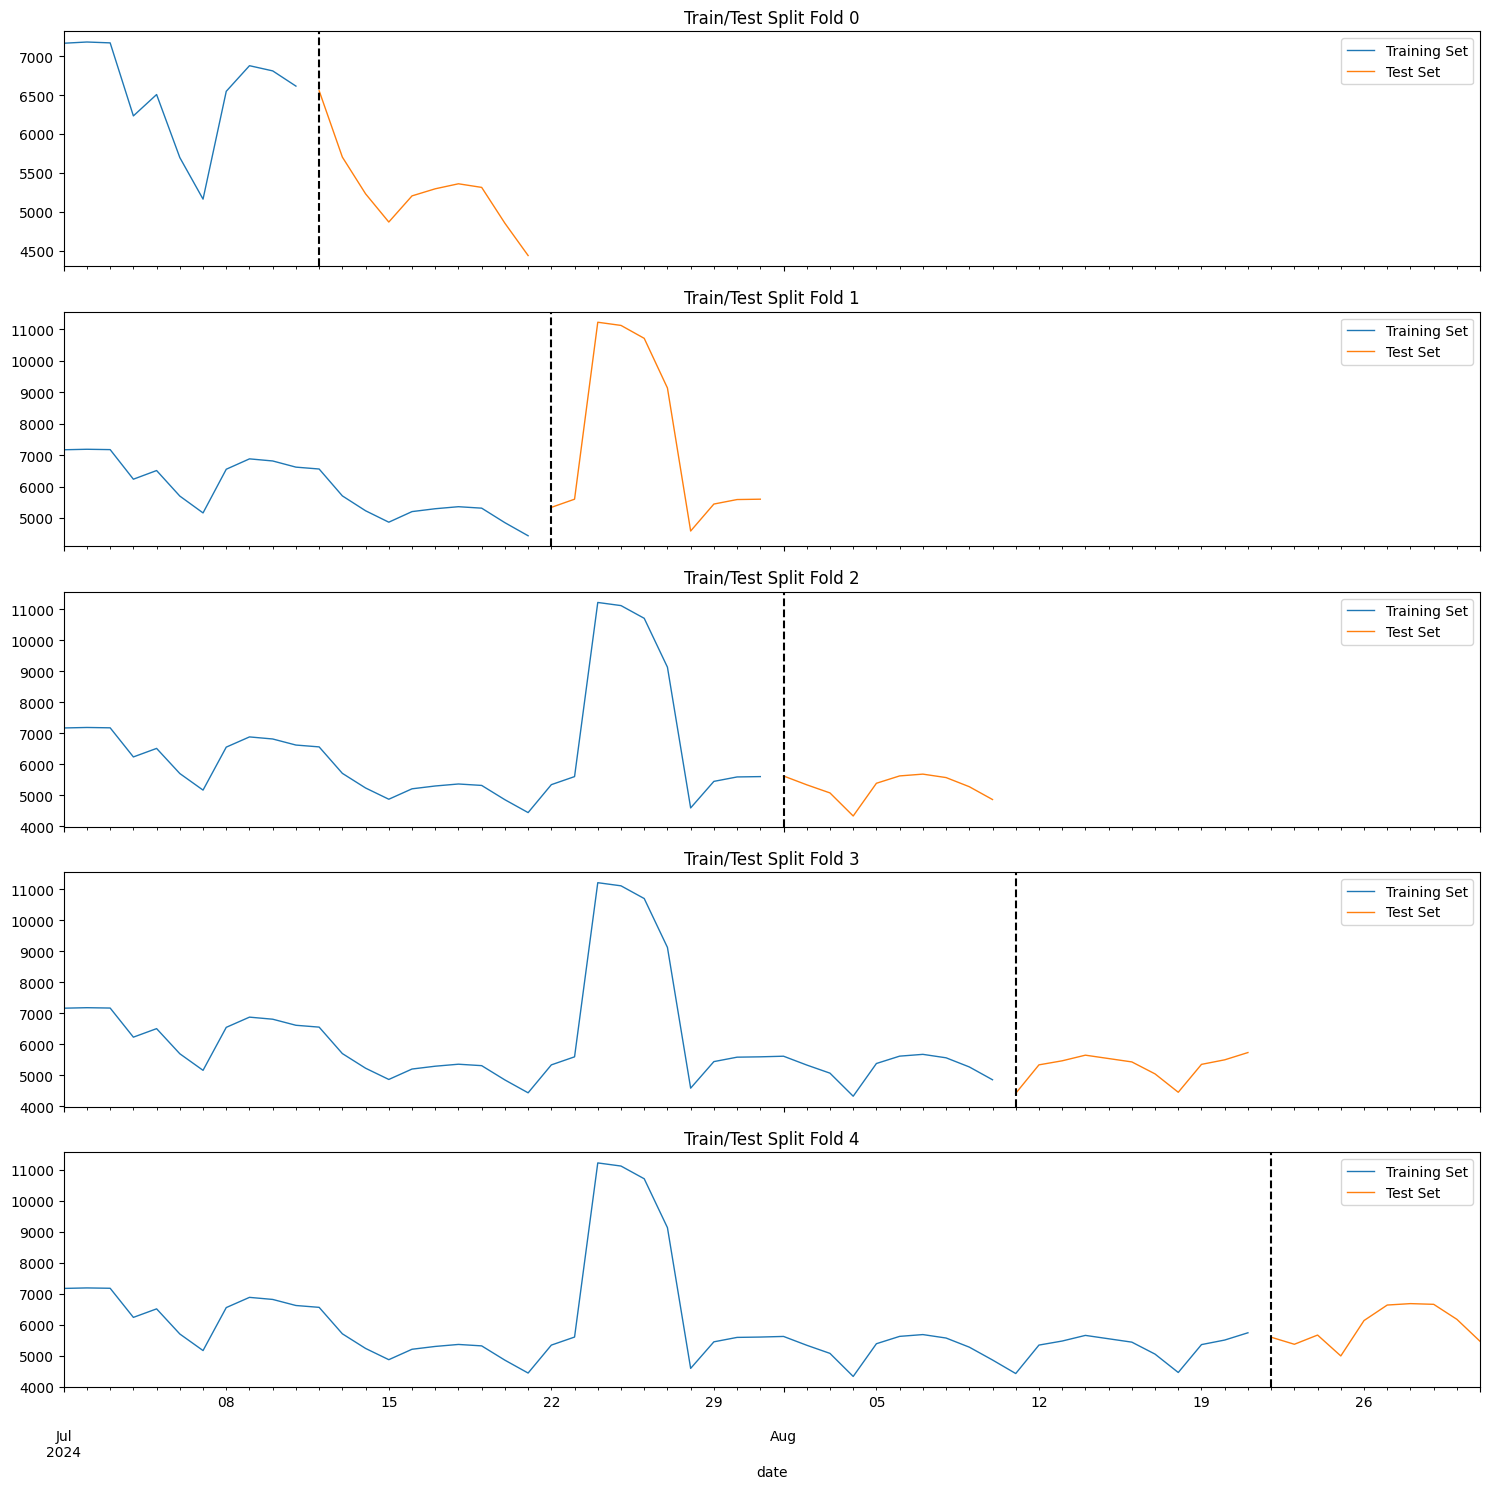

In [15]:
import matplotlib.pyplot as plt

# Set up subplots for each fold
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)  # Ensure number of subplots matches number of folds

fold = 0
for train_idx, val_idx in tscv.split(fc_clean):
    train = fc_clean.iloc[train_idx]
    test = fc_clean.iloc[val_idx]

    train['consumption'].plot(ax=axs[fold], lw=1,
                              label='Training Set',
                              title=f'Train/Test Split Fold {fold}')
    test['consumption'].plot(ax=axs[fold], lw=1,
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()  # Add legend for each subplot
    fold += 1

plt.tight_layout()
plt.show()

## Predicción del Futuro

Primero, se reentrena el modelo utilizando todos los datos disponibles. Esto permite aprovechar al máximo la información, ya que las predicciones se realizarán a partir de la última fecha registrada en el conjunto de datos:

In [16]:
#crear dataframe completo
fc_clean = create_attributes(fc_clean)

features = ['day','dayofweek','month','quarter','year','dayofyear']
target = ['consumption']

X_full = fc_clean[features]
y_full = fc_clean[target]

In [17]:
# Crear instancia del regresor con los mejores hiperparámetros
xgb_regf = xgb.XGBRegressor(
    booster='gbtree',
    seed=42,
    n_estimators=125,  # Ajustado según el mejor resultado
    early_stopping_rounds=50,
    objective='reg:squarederror',
    reg_lambda=2.8547,  # Mejor valor para reg_lambda
    max_depth=3,        # Mejor valor para max_depth
    eta=0.1997          # Mejor valor para learning_rate (que corresponde a eta)
)

# Entrenar el modelo
xgb_regf.fit(
    X_full,
    y_full,
    eval_set=[(X_full, y_full)],
    verbose=100
)

[0]	validation_0-rmse:1247.34779
[100]	validation_0-rmse:31.31513
[124]	validation_0-rmse:23.41540


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.1997, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=125,
             n_jobs=None, num_parallel_tree=None, ...)

### Resultados

- **Inicio del entrenamiento**: En la primera iteración (0), el RMSE es **1398.93**, indicando que el modelo aún no hace predicciones precisas.
- **Mejoras a través de las iteraciones**: A medida que avanza el entrenamiento, el RMSE disminuye notablemente:
  - En la iteración 100, el RMSE es **518.71**.
  - En la iteración 200, el RMSE se reduce a **196.98**.
  - En la iteración 300, llega a **78.20**.
- **Convergencia**: En las últimas iteraciones, el RMSE sigue disminuyendo, aunque más lentamente:
  - En la iteración 600, el RMSE es **10.05**.
  - Finalmente, en la iteración 999, el RMSE se estabiliza en **2.27**.

### Conclusiones

1. **Buen ajuste**: El modelo muestra una mejora continua en su capacidad predictiva.
2. **Detención anticipada**: Si se usó `early_stopping_rounds=50`, el entrenamiento podría haberse detenido antes de alcanzar la iteración 999.

A continuación, se crea un nuevo dataframe que incluye las fechas a pronosticar. Posteriormente, este dataframe se concatena con el dataframe original, añadiendo una columna booleana para identificar las fechas correspondientes al futuro.

En este caso, se pronostican 4 meses hacia adelante. Para generar el rango de fechas en la frecuencia deseada, se utiliza el método `date_range` de Pandas, configurado para obtener fechas diarias:

In [18]:
#rango de septiembre a diciembre 2024
pred_dates = pd.date_range('2024-09-01','2024-12-31', freq='D')
preds_df = pd.DataFrame(index=pred_dates)

#Crear columna
preds_df['Future'] = True
fc_clean['Future'] = False

#Concatenar dataframes
pred_fc = pd.concat([fc_clean.loc[fc_clean.index >= '01-01-2018'], preds_df])

Se agregan atributos mediante la función `create_attributes` y, finalmente, se genera un dataframe con las fechas futuras para realizar el pronóstico. El dataframe "futuro" se usará como entrada del modelo, mientras que el dataframe "completo" permitirá visualizar la serie de tiempo final:

In [19]:
#agregar atributos
pred_fc = pred_fc.copy()
pred_fc = create_attributes(pred_fc)

#seleccionar fechas
future_pred_fc = pred_fc.query('Future').copy()
future_pred_fc.head()

,consumption,day,dayofweek,month,quarter,year,dayofyear,Future
2024-09-01,NaN,1,6,9,3,2024,245,True
2024-09-02,NaN,2,0,9,3,2024,246,True
2024-09-03,NaN,3,1,9,3,2024,247,True
2024-09-04,NaN,4,2,9,3,2024,248,True
2024-09-05,NaN,5,3,9,3,2024,249,True


# Pronóstico

Se asignan los valores pronosticados a una nueva columna llamada `prediction`, y finalmente, se genera una gráfica que muestra tanto los datos históricos como el pronóstico obtenido.

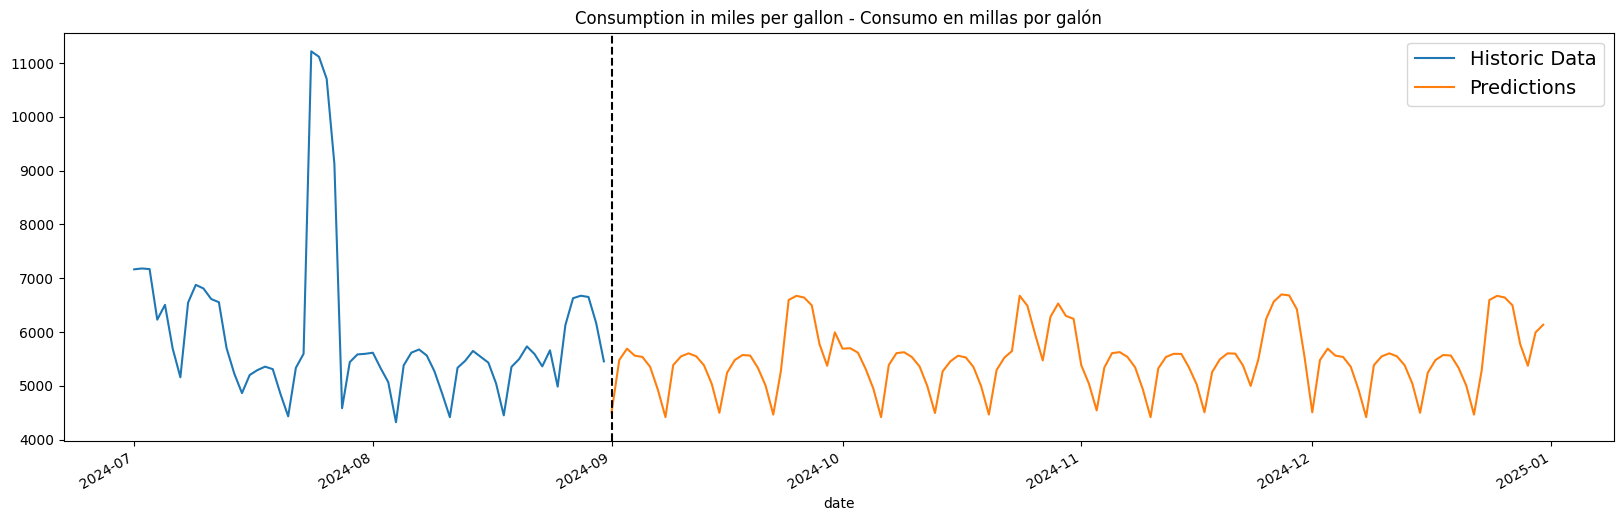

In [20]:
#predicciones del modelo
future_pred_fc['prediction'] = xgb_regf.predict(future_pred_fc[features])

#graficar
ax = fc_clean['consumption'].loc[fc_clean.index >= '01-01-2018']\
    .plot(figsize=(20, 6), lw=1.5, title='Consumption in miles per gallon - Consumo en millas por galón')
future_pred_fc['prediction'].plot(style='-', lw=1.5)
ax.axvline('2024-09-01', color='black', ls='--', lw=1.5)
plt.legend(['Historic Data','Predictions'], fontsize=14)
plt.show()